# **Credit Card Fraud Detection**

*Les dades del dataset son de titulars europeus recollides durant 2 dies de setembre de 2013, amb un total de 492 fraus en 284,807 transaccions. El desbalaceig entre transaccions legítimes i fraudulentes és significatiu, amb un 0,172% de transaccions classificades com a fraus. Les característiques numèriques del conjunt de dades, derivades d'una transformació PCA, inclouen components principals (V1 a V28), mentre que 'Time' i 'Amount' no han estat subjectes a aquesta transformació.*

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import norm
import joblib

import imblearn
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.combine import SMOTEENN

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_predict, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import *
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE


In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploratory Data Analysis



Iniciarem l'anàlisi exploratori de dades per obtenir una millor comprensió de les característiques del conjunt de dades. Aquesta fase ens permetrà explorar les propietats, distribució i relacions de les variables presents en el dataset, facilitant així una visió completa de la informació continguda.


**Objectius de l'EDA:**

1. *Relació entre Time i Fraus:*
   - Investigarem la relació entre el temps (Time) i les transaccions fraudulentes, horari o canvi horari.

2. *Relació entre Amount i Fraus:*
   - Explorarem la relació entre l'import de les transaccions (Amount) i la presència de fraus.

3. *Anàlisi d'Outliers:*
   - Identificarem i analitzarem possibles outliers que puguin afectar la integritat del conjunt de dades.


**Possibles Hipòtesis:**

- Les transaccions fraudulentes podrien mostrar patrons específics en la seva relació amb el temps o l'import.
- Les transaccions fraudulentes podrien representar de bona part de les transaccions fraudulentes.

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


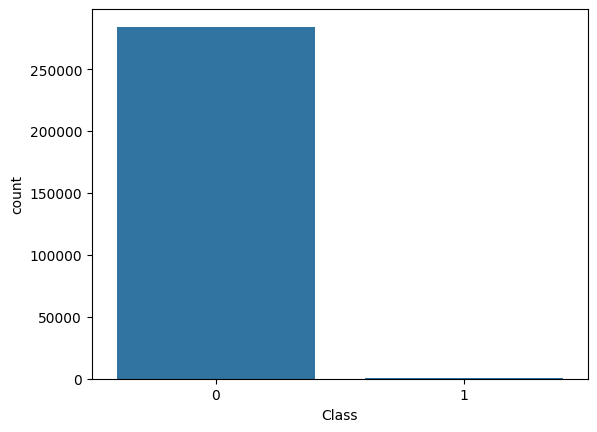

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [4]:
sns.countplot(x='Class', data=df)
plt.show()
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

In [11]:
print(f'Null values: {df.isnull().sum().sum()}')

Null values: 0


La notable desproporció entre les transaccions fraudulentes i no fraudulentes presenta un desafiament significatiu en la resolució d'aquest problema. Afortunadament, el nostre conjunt de dades no conté valors NaN, eliminant la necessitat de tractament en aquest aspecte.

###  Analisis de Amount and Time.

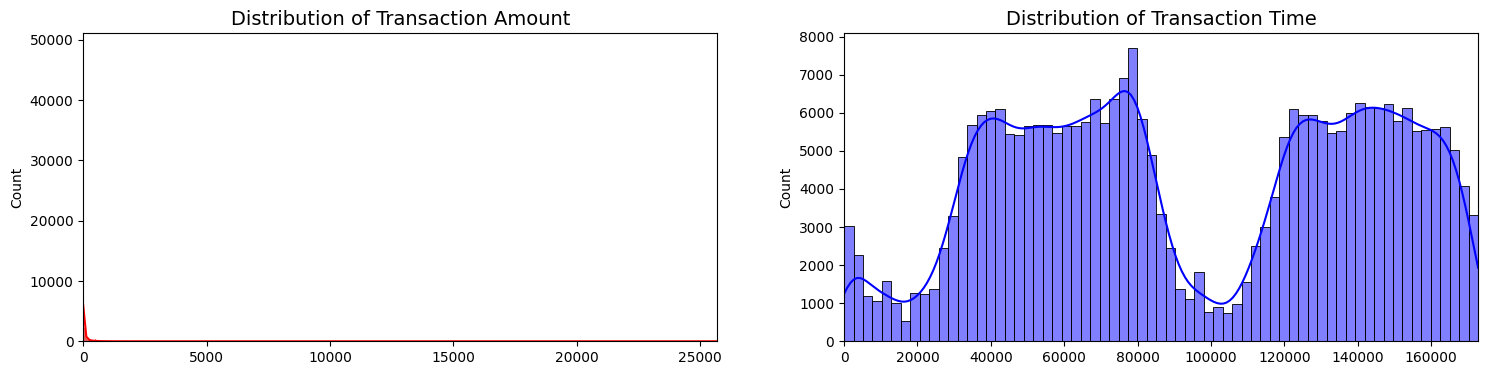

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()


La majoria de les transaccions es troben en l'interval inferior a 100 euros. A més, observem una disminució significativa en el nombre de transaccions durant la nit, des de les 00:00h fins a les 08:00h aproximadament.


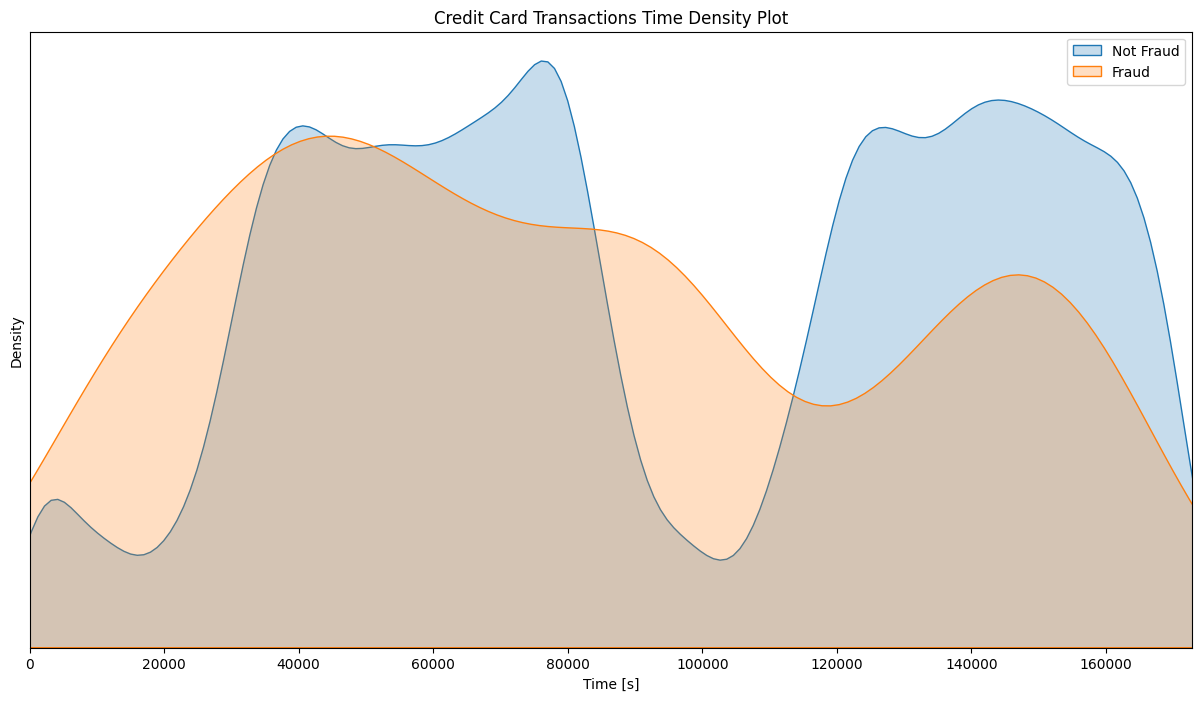

In [13]:
plt.figure(figsize=(15, 8))

class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

sns.kdeplot(class_0, label='Not Fraud', fill=True)
sns.kdeplot(class_1, label='Fraud', fill=True)

plt.title('Credit Card Transactions Time Density Plot')
plt.xlabel('Time [s]')
plt.ylabel('Density')

plt.legend()
plt.yticks([])
plt.xlim(0, max(df['Time']))

plt.show()


És notable que el nombre de transaccions fraudulentes manté una major estabilitat en comparació amb les transaccions vàlides. Això suggereix que les transaccions fraudulentes ocorren amb una freqüència relativament constant, tant durant el dia com durant la nit.

Seguidament mirarem las diferents distribucions de Amount i Time basantnos en les diferents hores del dia.

In [5]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
data = pd.DataFrame(tmp)
data.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
data

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.00,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.00,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.00,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.00,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.00,4002.88,1555,106989.39,68.803466,17.900,45355.430437
...,...,...,...,...,...,...,...,...,...
89,45.0,1,12.31,39.98,2,52.29,26.145000,26.145,382.814450
90,46.0,0,0.00,25691.16,6458,449369.58,69.583397,15.000,132269.354973
91,46.0,1,0.00,634.30,6,1433.23,238.871667,194.490,67185.062017
92,47.0,0,0.00,10199.44,4852,333212.69,68.675328,14.000,56123.940988


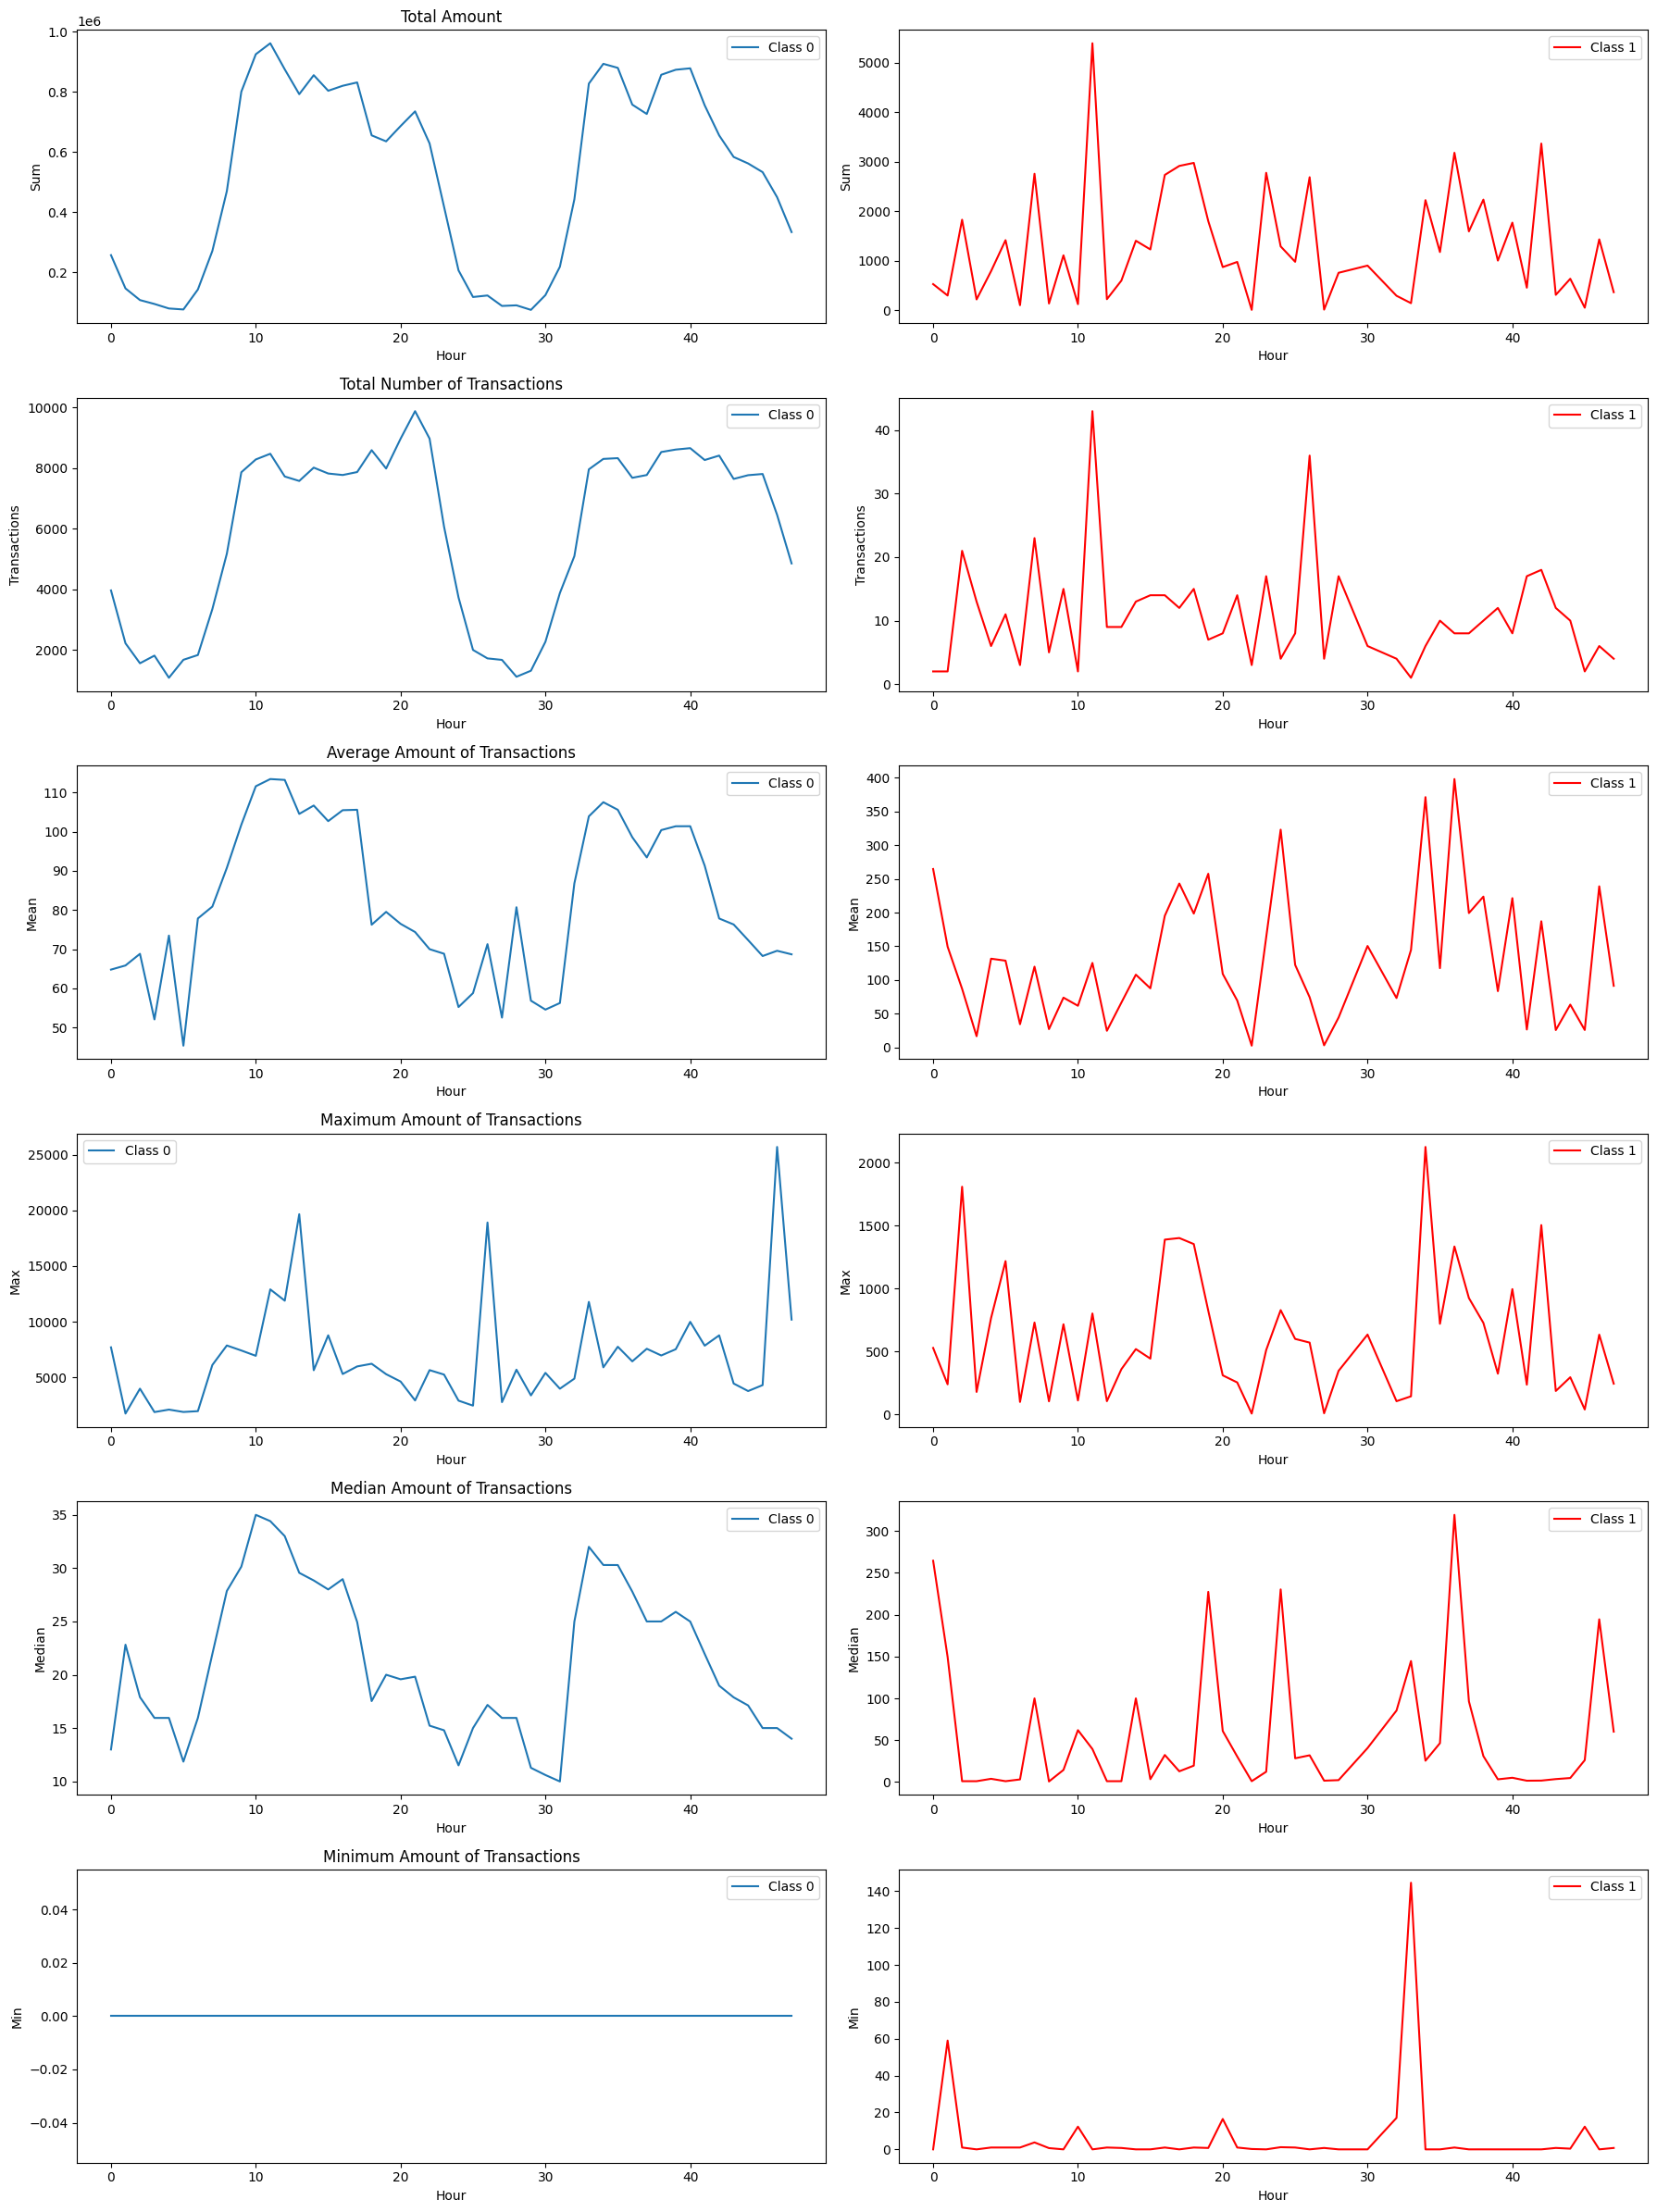

In [15]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(18, 24))

s1 = sns.lineplot(ax=axs[0, 0], x="Hour", y="Sum", data=data.loc[data.Class==0], label="Class 0")
s2 = sns.lineplot(ax=axs[0, 1], x="Hour", y="Sum", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[0, 0].set_title("Total Amount")

s3 = sns.lineplot(ax=axs[1, 0], x="Hour", y="Transactions", data=data.loc[data.Class==0], label="Class 0")
s4 = sns.lineplot(ax=axs[1, 1], x="Hour", y="Transactions", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[1, 0].set_title("Total Number of Transactions")

s5 = sns.lineplot(ax=axs[2, 0], x="Hour", y="Mean", data=data.loc[data.Class==0], label="Class 0")
s6 = sns.lineplot(ax=axs[2, 1], x="Hour", y="Mean", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[2, 0].set_title("Average Amount of Transactions")

s7 = sns.lineplot(ax=axs[3, 0], x="Hour", y="Max", data=data.loc[data.Class==0], label="Class 0")
s8 = sns.lineplot(ax=axs[3, 1], x="Hour", y="Max", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[3, 0].set_title("Maximum Amount of Transactions")

s9 = sns.lineplot(ax=axs[4, 0], x="Hour", y="Median", data=data.loc[data.Class==0], label="Class 0")
s10 = sns.lineplot(ax=axs[4, 1], x="Hour", y="Median", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[4, 0].set_title("Median Amount of Transactions")

s11 = sns.lineplot(ax=axs[5, 0], x="Hour", y="Min", data=data.loc[data.Class==0], label="Class 0")
s12 = sns.lineplot(ax=axs[5, 1], x="Hour", y="Min", data=data.loc[data.Class==1], color="red", label="Class 1")
axs[5, 0].set_title("Minimum Amount of Transactions")

for ax in axs.flatten():
    ax.legend()

plt.tight_layout()
plt.show()

Podem observar que, en general, mentre les transaccions vàlides segueixen un patró horari bastant precís, les transaccions fraudulentes presenten una distribució més sorollosa i contínua. Aquesta variabilitat podria ser d'interès per a la detecció de transaccions fraudulentes basada en l'horari.

### Analisis d'outliers

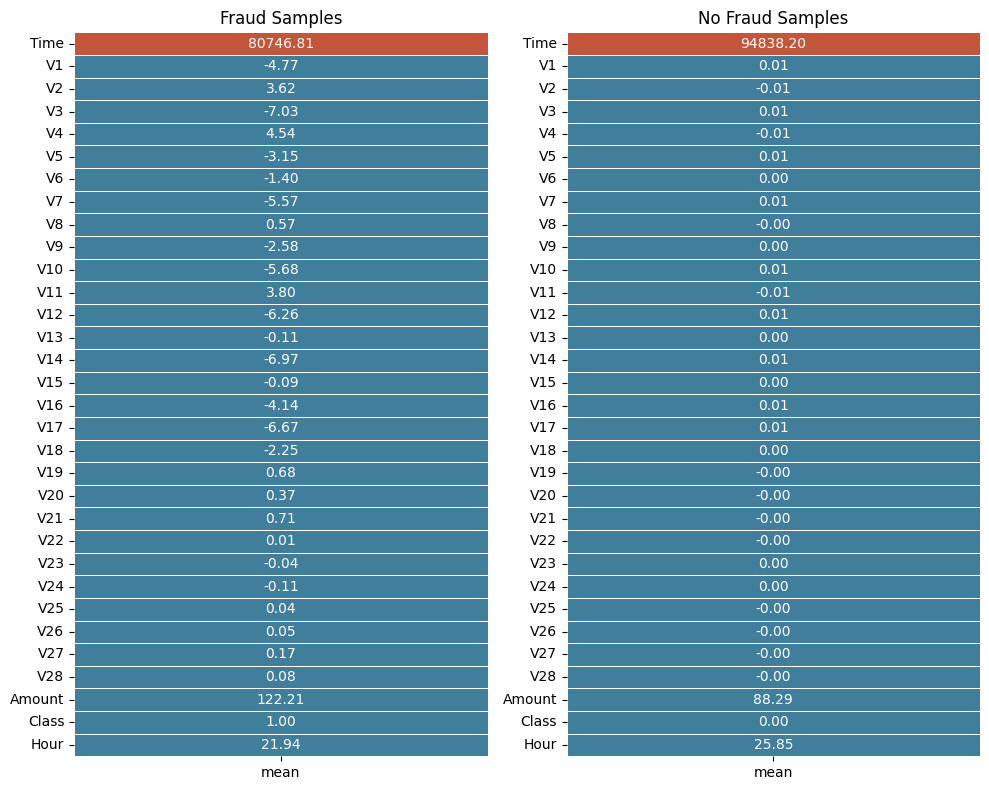

In [16]:
fraud = df[df['Class'] == 1].describe().T
nofraud = df[df['Class'] == 0].describe().T

cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (10,8))
plt.subplot(1,2,1)
sns.heatmap(fraud[['mean']][:],annot = True,cmap=cmap,linewidths=0.5, linecolor='white', cbar = False,fmt = '.2f')
plt.title('Fraud Samples');

plt.subplot(1,2,2)
sns.heatmap(nofraud[['mean']][:],annot = True,cmap=cmap, linewidths=0.5, linecolor='white', cbar = False,fmt = '.2f')
plt.title('No Fraud Samples');

fig.tight_layout()

Podem observar que la majoria de les transaccions no fraudulentes tenen una mitjana d'aproximadament 0 per a totes les característiques derivades del PCA, mentre que les transaccions fraudulentes presenten variabilitat i irregularitat. A més, es poden observar diferències notables en la mitjana de 'Amount' (quantitat) i 'Hour' (temps).

In [5]:
feature_names = df.columns.drop(['Time', 'Hour'])

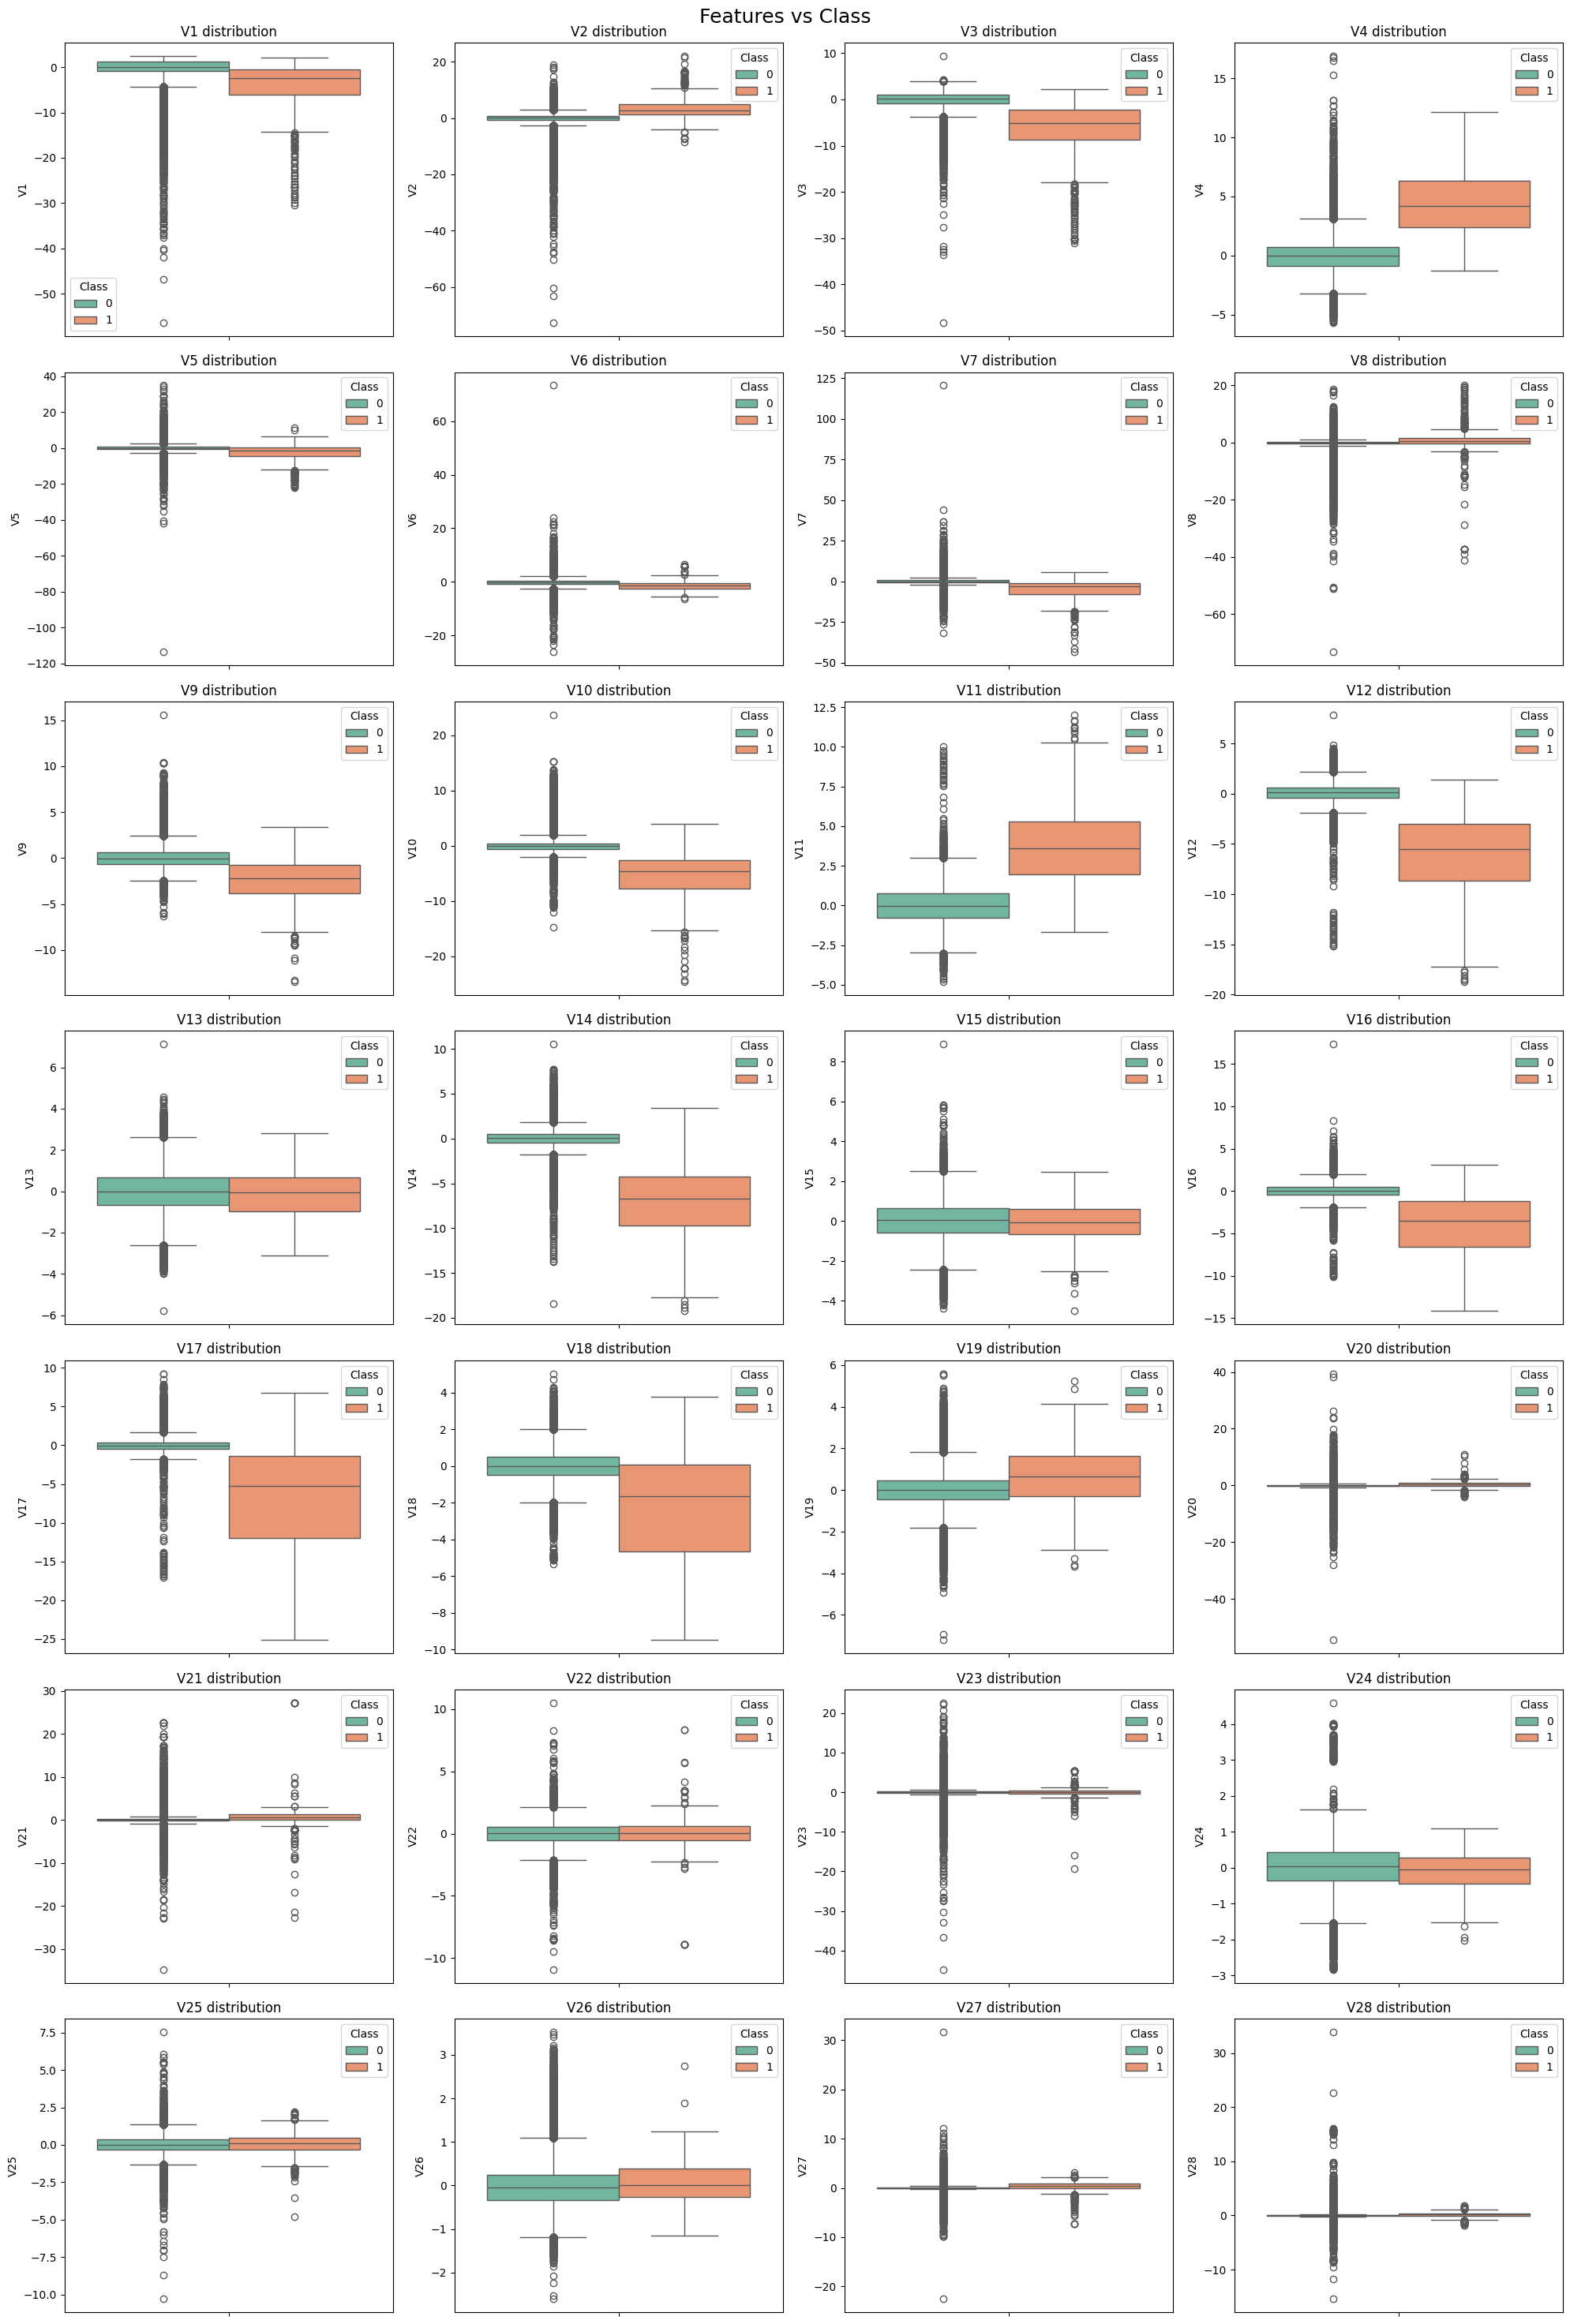

In [18]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 30))
fig.suptitle('Features vs Class\n', size=18)

for i, ax in zip(feature_names, axes.flatten()):
    sns.boxplot(ax=ax, data=df, hue='Class', y=i, palette="Set2")
    ax.set_title(i + ' distribution')

plt.tight_layout()


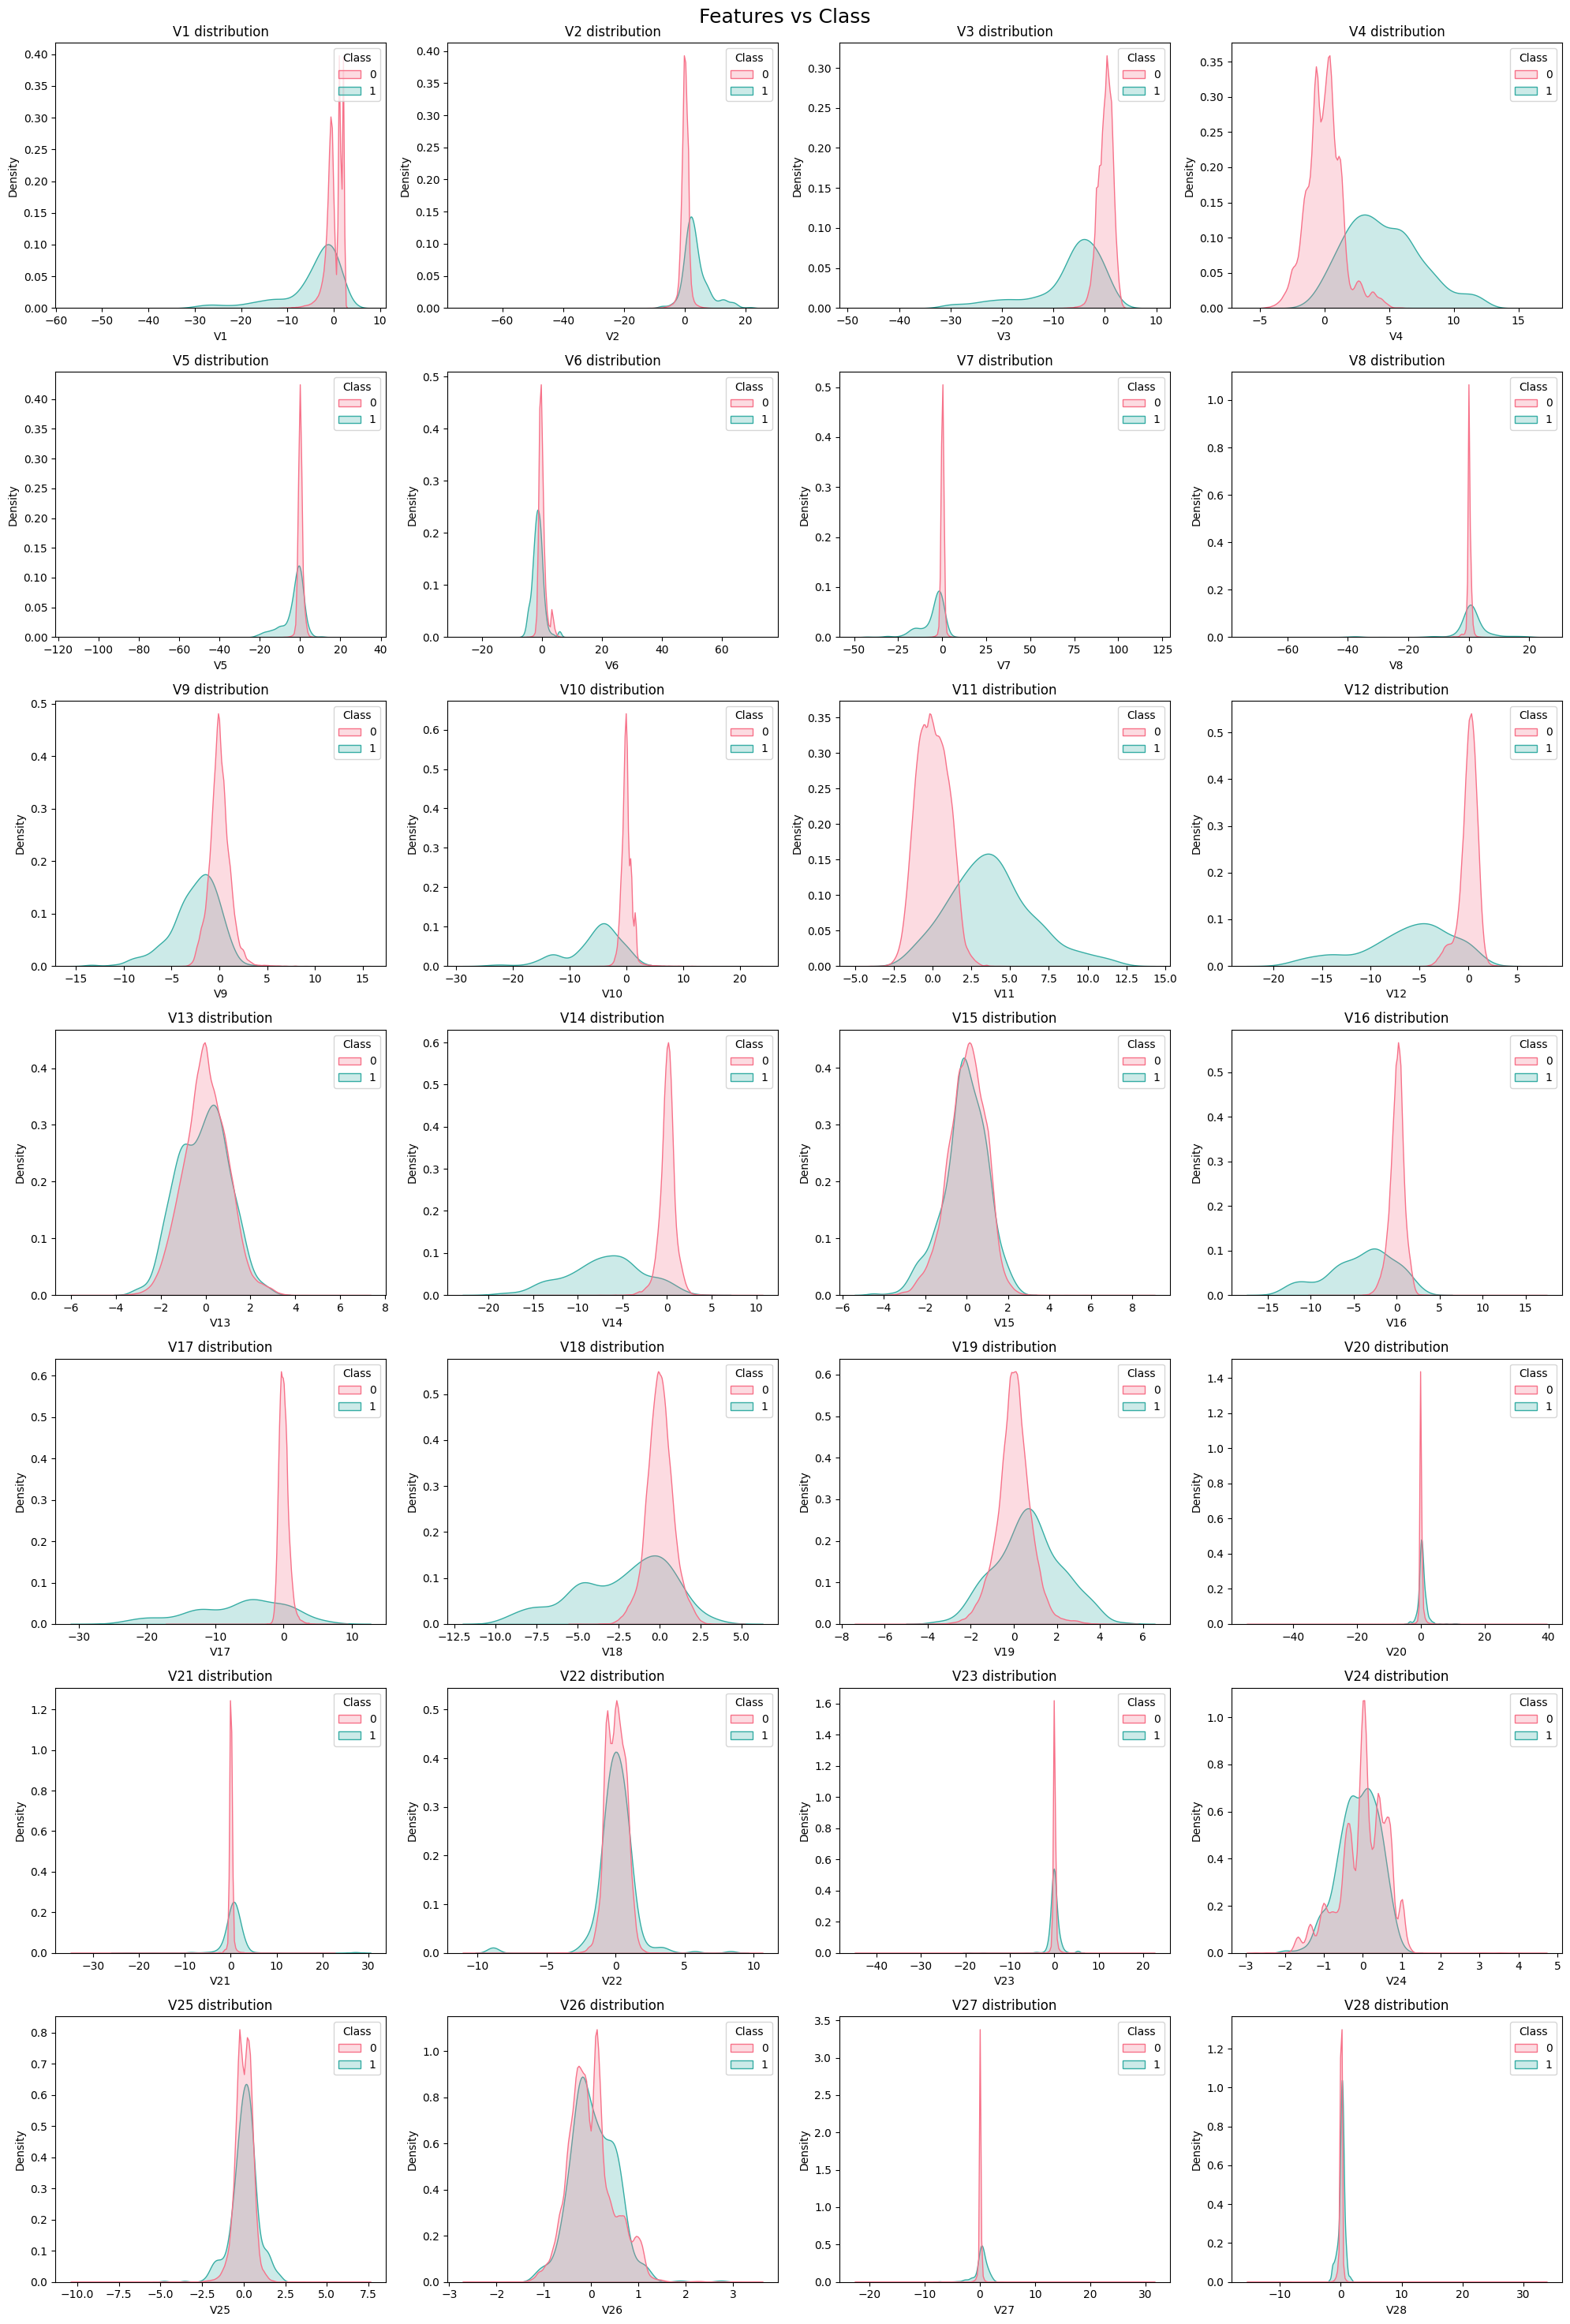

In [19]:
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 30))
fig.suptitle('Features vs Class\n', size=18)

for i, ax in zip(feature_names, axes.flatten()):
    sns.kdeplot(data=df, x=i, hue='Class', fill=True, common_norm=False, ax=ax, palette='husl')
    ax.set_title(i + ' distribution')

plt.tight_layout()
plt.show()

Com podem observar, hi ha una bona quantitat d'outliers dins del nostre dataset, i es pot apreciar que molts d'aquests podrien constituir una part significativa de les mostres de transaccions fraudulentes. A continuació, observarem què passa si apliquem la tècnica IQR (rang interquartil) al nostre dataset.

In [8]:
def IQR_method(df, n, features):
    outlier_list = []
    total_outliers = 0
    
    for column in features:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1
        outlier_step = n * IQR
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
        outlier_list.extend(outlier_list_column)
    
    outlier_counter = Counter(outlier_list)
    multiple_outliers = [index for index, count in outlier_counter.items() if count > n]
    
    print('Total number of outliers is:', len(multiple_outliers))
    
    return multiple_outliers

In [10]:
feature_list = df.columns.drop('Class')

Outliers_IQR = IQR_method(df,8,feature_list)
df_outliers = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)
print(f'Dataset sense outliers: {df_outliers.shape[0]}\n', f'Dataset original: {df.shape[0]}')

Total number of outliers is: 114
Dataset sense outliers: 284693
 Dataset original: 284807


In [12]:
print ('The amount of frauds in df before dropping outliers: ', len(df[df['Class'] == 1]))
print ('The amount of frauds in df after dropping outliers: ', len(df_outliers[df_outliers['Class'] == 1]))

The amount of frauds in df before dropping outliers:  492
The amount of frauds in df after dropping outliers:  445


Com es pot observar, si eliminem la majoria dels outliers, perdrem una gran quantitat d'informació en les mostres de fraus. Per tant, de moment, no utilitzarem cap tractament d'outliers. Tot i això, podriem considerar l'opció de gestionar outliers extrems que podrien afegir soroll a les dades, amb la possibilitat de millorar el rendiment del nostre model.

### Correlation Analysis

A continuació, realitzaré un anàlisi de les correlacions per aprofundir en la comprensió del nostre conjunt de dades. No obstant això, és important tenir en compte que aquestes correlacions poden no ser definitives si utilitzem remostreig, ja que la nova distribució de dades pot modificar de manera significativa les correlacions a analitzar.

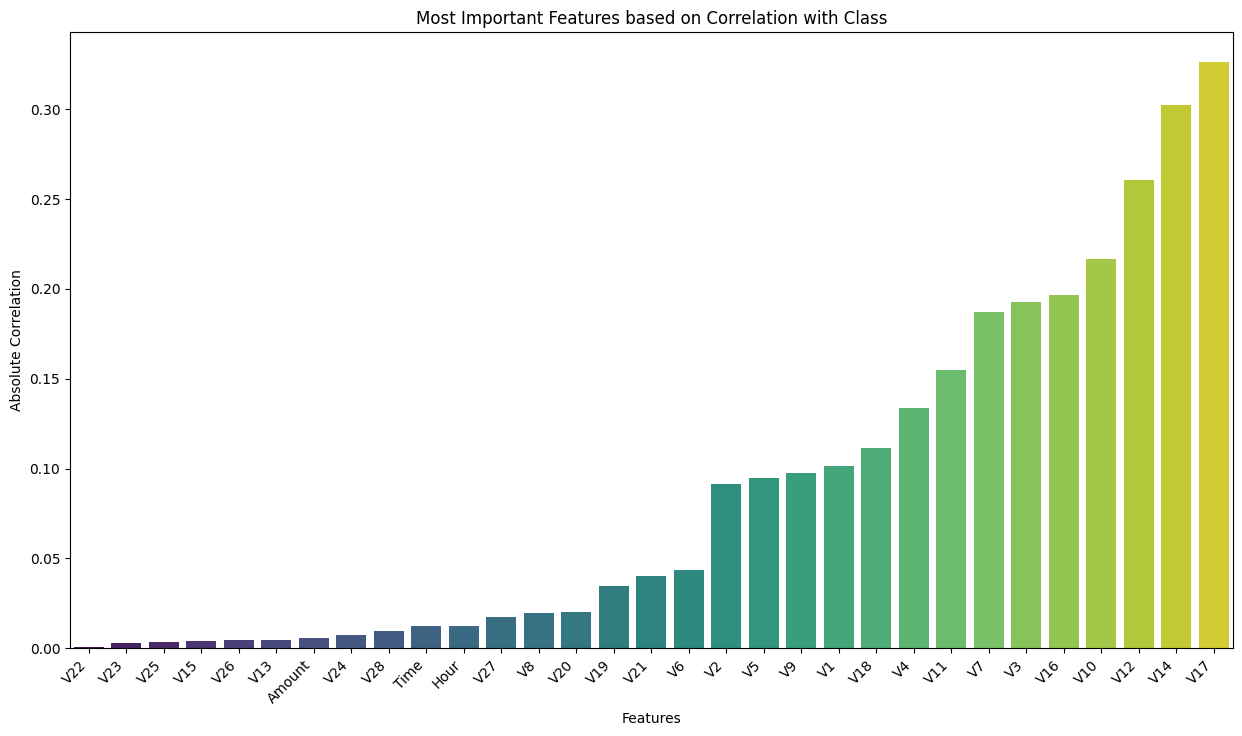

In [23]:
plt.figure(figsize=(15, 8))

correlation = df.corr()['Class'].abs().sort_values()
correlation = correlation[correlation.index != 'Class']

sns.barplot(x=correlation.index, y=correlation.values, hue=correlation.index,  palette='viridis')
plt.title('Most Important Features based on Correlation with Class')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')

plt.show()

<Figure size 1500x800 with 0 Axes>

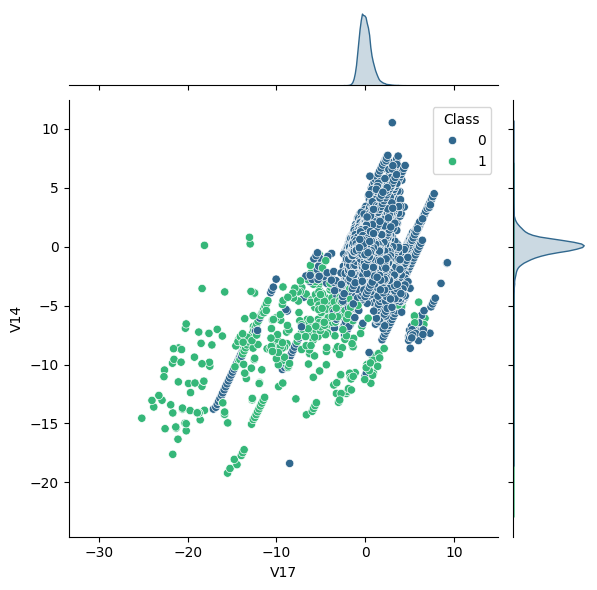

In [24]:
plt.figure(figsize=(15, 8))
sns.jointplot(x='V17', y='V14',hue='Class', data=df, palette ='viridis')
plt.show()

<Figure size 1500x800 with 0 Axes>

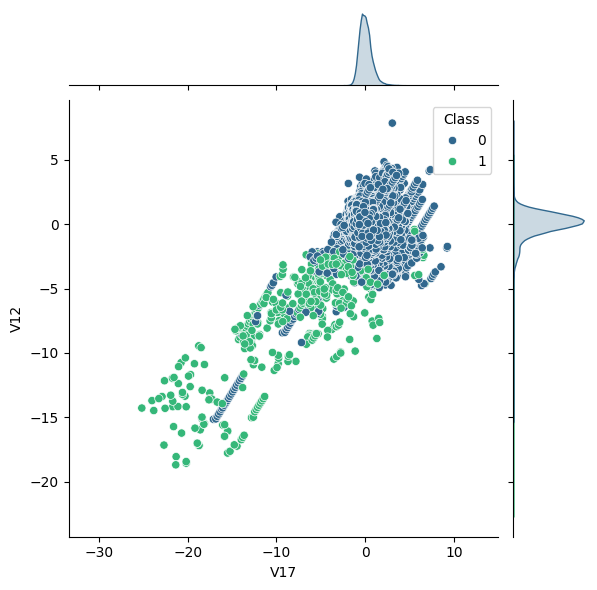

In [25]:
plt.figure(figsize=(15, 8))
sns.jointplot(x='V17', y='V12',hue='Class', data=df, palette ='viridis')
plt.show()

<Figure size 1500x800 with 0 Axes>

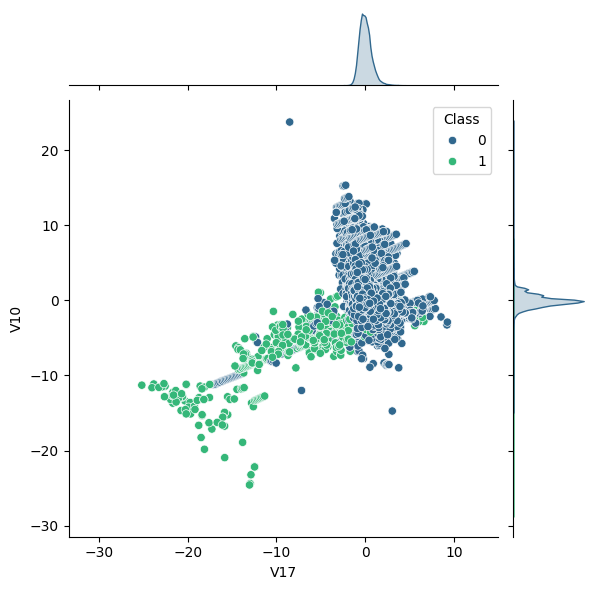

In [26]:
plt.figure(figsize=(15, 8))
sns.jointplot(x='V17', y='V10',hue='Class', data=df, palette ='viridis')
plt.show()

Com podem observar, el nostre conjunt de dades original presenta un desequilibri important en les correlacions entre les diferents característiques. Aquest anàlisi ens pot ajudar a realitzar una selecció de característiquesen un futur i veure com aquestes correlacions canvien en comparació amb les trobades en els conjunts de dades amb remostreig. A més, podem destacar que la relació entre les característiques més importants mostra una bona separabilitat entre classes, la qual cosa pot indicar que podrem obtenir bons resultats en els nostres models.

## Balancig Dataset

<img src="figs\imbalance.png" width="600">


En aquest apartat, explorarem les dues principals tècniques per abordar conjunts de dades desbalancejats: el preprocessament de dades o remostreig i l'aprenentatge sensible al cost. Avaluar les tècniques de remostreig més importants amb la llibreria Imbalanced-Learn serà la nostra prioritat, seguida d'una petita prova de models utilitzant la funció de cost modificada mitjançant *class_weight*.

1. **Under-Sampling:**
    - RandomUnderSampler *(Selecció de prototips)*
    - ClusterCentroids *(Generació de prototips)*

2. **Over-Sampling:**
    - SMOTE
    - ADASYN

3. **Combinació de Over-Sampling i Under-Sampling:**
    - SMOTEENN

4. **Aprenentatge Sensible al Cost:**
    - Simple Cost-Sensitive Models
    - Voting Classifier from Cost-Sensitive Models

Davant la naturalesa desbalancejada del conjunt de dades, es donarà prioritat a les mètriques F1-macro i àrea sota la corba de precisió-recuperació (PRAUC) durant l'avaluació dels models. Aquesta elecció es justifica pel fet que aquestes mètriques consideren de manera equitativa el rendiment de les dues classes, essent especialment útils en situacions de distribució desigual de les classes.

In [6]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def feature_selection(X, y, threshold=0.1):
    df = pd.concat([pd.DataFrame(X, columns=X_train.columns), pd.Series(y, name='Class')], axis=1)
    correlation = df.corr().iloc[:-1, -1].abs().sort_values()
    selected_features = correlation[correlation < threshold].index.tolist()
    display(selected_features) 
    return pd.DataFrame(X, columns=X_train.columns).drop(selected_features, axis=1)

def cross_validate_models(models, sampling_method, X, y, cv=stratified_kfold, resampeling='SMOTE'):
    f1macro_data = []

    for model in models:
        pipeline = make_pipeline(sampling_method, model)
        scoring_function = make_scorer(f1_score, average='macro')
        f1macro_score = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring_function).mean()
        f1macro_data.append(f1macro_score)

    f1macro_df = pd.DataFrame(f1macro_data, columns=['f1_macro'], index=[f"{model.__class__.__name__}_{hash(str(model))}" for model in models])
    display(f1macro_df) 
    return f1macro_df

def plot_curves_for_models(models, sampling_method, X, y):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    for model in models:
        pipeline = make_pipeline(sampling_method, model)

        y_scores_pr = cross_val_predict(pipeline, X, y, cv=5, method='predict_proba')[:, 1]
        precision, recall, _ = precision_recall_curve(y, y_scores_pr)
        auc_score_pr = auc(recall, precision)
        axes[0].plot(recall, precision, label=f'{model.__class__.__name__} (AUC = {auc_score_pr:.2f})')

        y_scores_roc = cross_val_predict(pipeline, X, y, cv=5, method='predict_proba')[:, 1]
        fpr, tpr, _ = roc_curve(y, y_scores_roc)
        auc_score_roc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {auc_score_roc:.2f})')

    axes[0].set_title('Precision-Recall Curve')
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    axes[0].legend()

    axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    
def cross_validate_sensitive(models, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)):
    f1macro_data = []

    for model in models:
        scoring_function = make_scorer(f1_score, average='macro')
        f1macro_score = cross_val_score(model, X, y, cv=cv, scoring=scoring_function).mean()
        f1macro_data.append(f1macro_score)

    f1macro_df = pd.DataFrame(f1macro_data, columns=['f1_macro'], index=[f"{model.__class__.__name__}_{hash(str(model))}" for model in models])
    display(f1macro_df) 
    return f1macro_df

def plot_pr_curve(models, X, y):
    plt.figure(figsize=(10, 6))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

    for model in models:
        predictions = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        precision, recall, _ = precision_recall_curve(y, predictions[:, 1])
        auc_score = auc(recall, precision)  

        plt.plot(recall, precision, label=f'{model.__class__.__name__} (AUC: {auc_score:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid()
    plt.show()

Remostrejarla classe minoritària abans de la validació creuada pot generar problemes de overfitting. Quan es realitza la remostrejos abans de la validació creuada, duplicar entrades o crear dades sintètiques idèntiques a les que ja existeixen pot resultar en entrenar el classificador amb instàncies similars a les que s'estan validant. Això anul·la l'objectiu de la validació creuada, ja que algunes iteracions poden incloure instàncies a l'entrenament que són extremadament iguals a les de la validació, provocant overfiting i resultats enganyosos. Per abordar això, el remostreig s'hauria de fer durant la validació creuada, assegurant-se que les dades sintètiques es generin interpolant només gravacions que no s'utilitzen per a la validació. 
[Más informació](https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation)


<div style="text-align: center; padding: 20px;">
  <img src="figs/cv_fig1.jpg" width="400" style="margin: 0 auto;">
</div>

<div style="text-align: center; padding: 20px;">
  <img src="figs/cv_fig2.jpg" width="390" style="margin: 0 auto;">
</div>


A continuació, procedirem a normalitzar i dividir el nostre conjunt de dades en les parts d'entrenament i de prova. Aquest pas inicial és essencial per a la preparació de les dades, ja que ens permetrà aplicar les transformacions necessàries, així com entrenar i avaluar els models amb una metodologia separada per evitar la filtració d'informació del conjunt de prova al d'entrenament.

In [38]:
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

robust_scaler = RobustScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=33, stratify=y
)

In [39]:
n_value = 8
outliers_indices = IQR_method(X_train, n_value, X_train.columns)

X_train_outliers = X_train.drop(outliers_indices)
y_train_outliers = y_train.drop(outliers_indices)

Total number of outliers is: 92


In [40]:
X_train = robust_scaler.fit_transform(X_train)
X_train_outliers = robust_scaler.transform(X_train_outliers)
X_test_scaled = robust_scaler.transform(X_test)

### **Under-Sampling**

En aquesta secció, abordarem l'impacte de l'under-sampling en el nostre conjunt de dades altament desbalancejat. Examinarem diversos algoritmes que implementen diferents estratègies per gestionar la creació d'un conjunt de dades balancejat mitjançant la reducció de la classe majoritària. A més, avaluarem si l'aplicació d'aquesta tècnica implica una pèrdua significativa d'informació, ja que redueix la classe majoritària de manera dràstica, amb la possibilitat de perdre dades rellevants per a la correcta classificació d'aquesta.

Especialment, explorarem dos enfocaments per abordar aquest problema: **Prototype selection** amb *RandomUnderSampler* i **Prototype generation** amb *ClusterCentroids*.

#### <u>RandomUnderSampler *(Prototype selection)*</u>
Els algorismes de selecció de prototips seleccionaran mostres del conjunt original $S$. Per tant, $S'$ es defineix de manera que $S' \subseteq S$ i $S' \neq S$. Això implica que la tria dels exemples per al nou conjunt de dades és crítica per mantenir una distribució representativa de la classe reduïda.

In [25]:
rus = RandomUnderSampler(random_state=33)
X_train_RUS, y_train_RUS = rus.fit_resample(X_train, y_train)

#### <u>ClusterCentroids *(Prototype generation)*</u>
Per altre banda, els algoritmes de Prototype Generatin, donada una base de dades original $S$, els algorismes de generació de prototips generaran un nou conjunt $S'$. On $S' \subseteq S$ i $S' \neq S$. En altres paraules, la tècnica de generació de prototips reduirà el nombre de mostres a les classes objectiu, però les mostres restants seran generades i no seleccionades del conjunt original.Aquest enfocament intenta preservar la informació mentre crea mostres sintètiques, millorant la diversitat i la capacitat de generalització del model.

In [26]:
cc = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=33
)
X_train_CC, y_train_CC = cc.fit_resample(X_train, y_train)

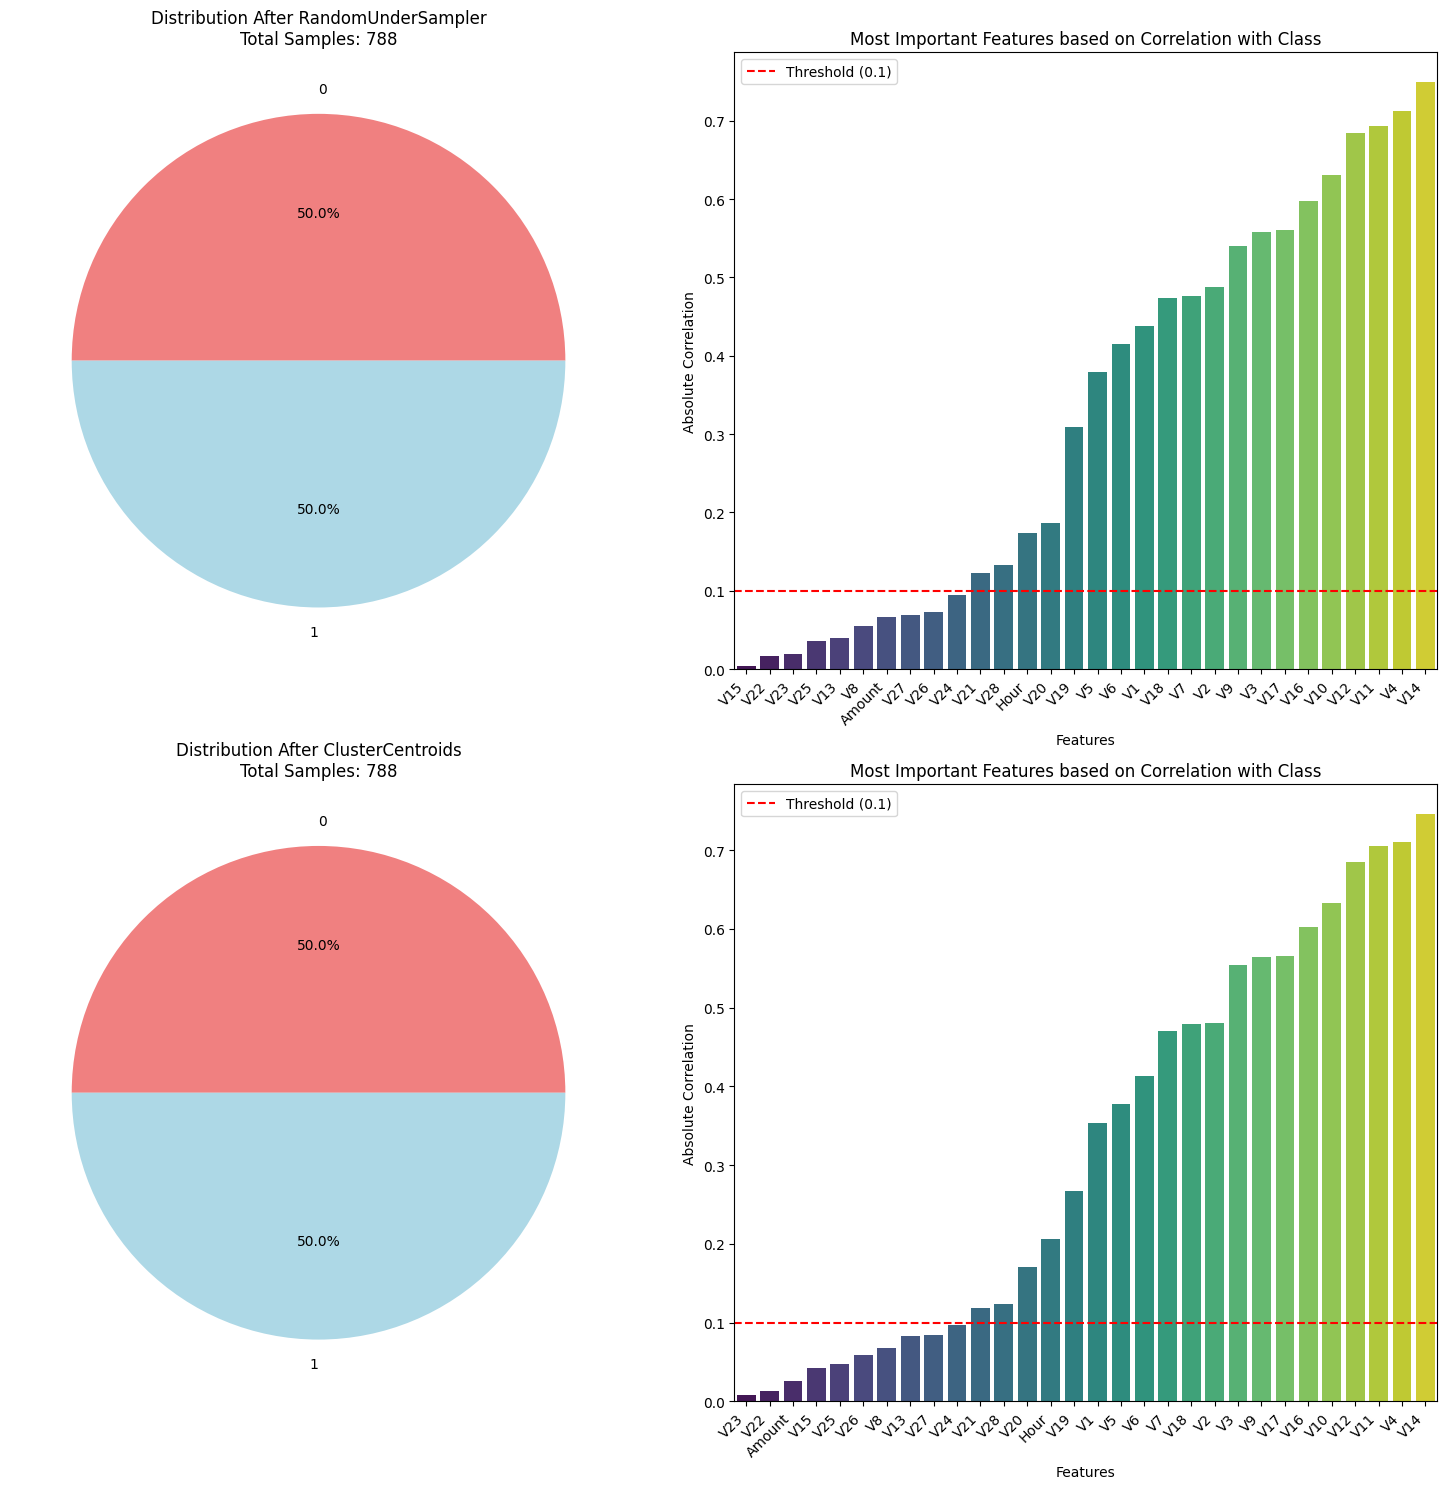

In [28]:
class_counts_after_rus = Counter(y_train_RUS)
class_counts_after_cc = Counter(y_train_CC)
corr_threshold = 0.1

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.pie(class_counts_after_rus.values(), labels=class_counts_after_rus.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Distribution After RandomUnderSampler\nTotal Samples: {}'.format(sum(class_counts_after_rus.values())))

plt.subplot(2, 2, 2)
RUS_df = pd.concat([pd.DataFrame(X_train_RUS, columns=X.columns), pd.Series(y_train_RUS, name='Class')], axis=1)
correlation = RUS_df.corr()['Class'].abs().sort_values()
correlation = correlation[correlation.index != 'Class']
sns.barplot(x=correlation.index, y=correlation.values, hue=correlation.index, palette='viridis')
plt.title('Most Important Features based on Correlation with Class')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=corr_threshold, color='red', linestyle='--', label=f'Threshold ({corr_threshold})')
plt.legend()

plt.subplot(2, 2, 3)
plt.pie(class_counts_after_cc.values(), labels=class_counts_after_cc.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Distribution After ClusterCentroids\nTotal Samples: {}'.format(sum(class_counts_after_cc.values())))

plt.subplot(2, 2, 4)
CC_df = pd.concat([pd.DataFrame(X_train_CC, columns=X.columns), pd.Series(y_train_CC, name='Class')], axis=1)
correlation = CC_df.corr()['Class'].abs().sort_values()
correlation = correlation[correlation.index != 'Class']
sns.barplot(x=correlation.index, y=correlation.values, hue=correlation.index, palette='viridis')
plt.title('Most Important Features based on Correlation with Class')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=corr_threshold, color='red', linestyle='--', label=f'Threshold ({corr_threshold})')
plt.legend()

plt.tight_layout()

Com havíem predit, es pot observar un canvi notable en la distribució de les dades amb més correlació amb el frau, augmentant la correlació en les variables més importants i canviant l'ordre de rellevància d'aquestes per a les diferents tècniques d'undersampling. Aquesta variació en les correlacions destaca la influència directa de l'undersampling en la relació entre les característiques i les transaccions fraudulentes, ressaltant la importància d'aquesta tècnica en la modificació de l'estructura i les relacions del conjunt de dades.

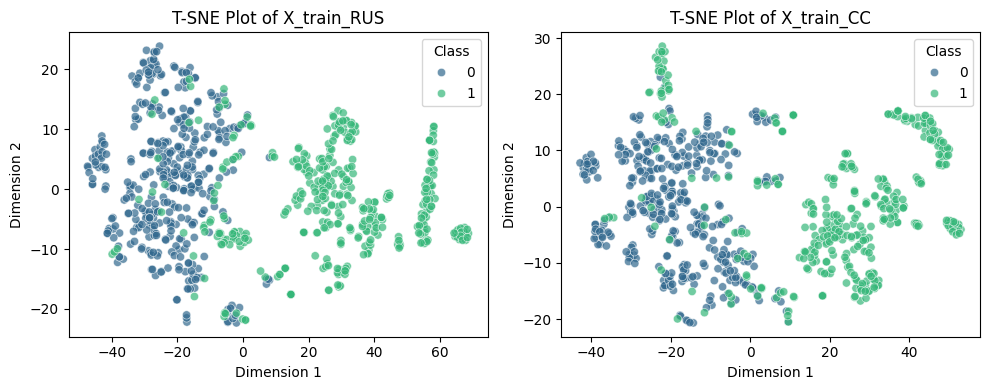

In [36]:
X_reduced_tsne_rus = TSNE(n_components=2, random_state=42).fit_transform(X_train_RUS)
tsne_df_rus = pd.DataFrame(X_reduced_tsne_rus, columns=['Dimension 1', 'Dimension 2'])
tsne_df_rus['Class'] = y_train_RUS

X_reduced_tsne_cc = TSNE(n_components=2, random_state=42).fit_transform(X_train_CC)
tsne_df_cc = pd.DataFrame(X_reduced_tsne_cc, columns=['Dimension 1', 'Dimension 2'])
tsne_df_cc['Class'] = y_train_CC

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Class', data=tsne_df_rus, palette='viridis', alpha=0.7, ax=axes[0])
axes[0].set_title('T-SNE Plot of RUS')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')

sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Class', data=tsne_df_cc, palette='viridis', alpha=0.7, ax=axes[1])
axes[1].set_title('T-SNE Plot of CC')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()


La representació T-SNE de l'espai generat per RandomUnderSampler i ClusterCentroids mostra una clara separació entre les classes, indicant que els models entrenats en aquestes dades podrien oferir un bon rendiment en la classificació.

#### Classifiers

In [70]:
models = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42)
]

In [71]:
resultsRUS = cross_validate_models(models, rus, X_train, y_train, metrics=['accuracy', 'precision', 'recall', 'f1_macro'], cv=stratified_kfold, resampeling='RUS')

,f1_macro
LogisticRegression_3879272089544194457,0.528688
KNeighborsClassifier_-7634219998417779741,0.536421
RandomForestClassifier_6939949726593806787,0.537290
XGBClassifier_-2460739881445598764,0.531083


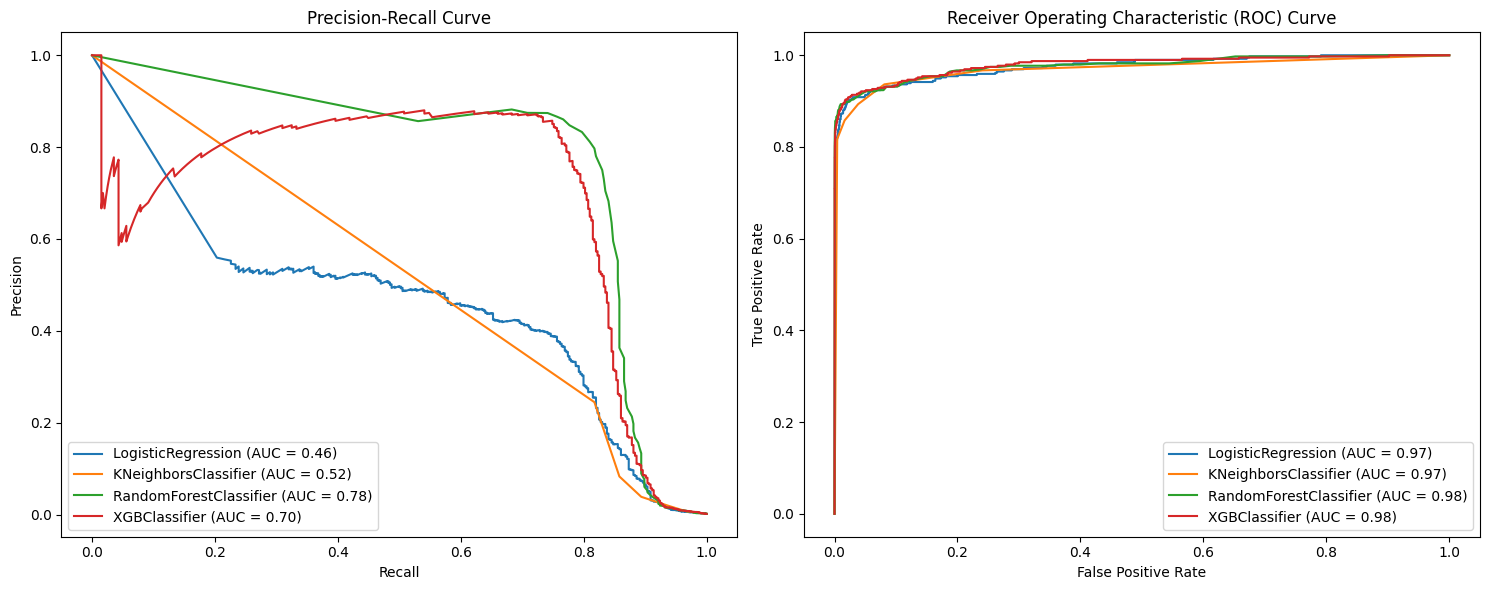

In [86]:
plot_curves_for_models(models, rus, X_train, y_train)

In [74]:
resultsCC = cross_validate_models(models, cc, X_train, y_train, metrics=['accuracy', 'precision', 'recall', 'f1_macro'], cv=stratified_kfold, resampeling='CC')

,f1_macro
LogisticRegression_3879272089544194457,0.523908
KNeighborsClassifier_-7634219998417779741,0.614461
RandomForestClassifier_6939949726593806787,0.455798
XGBClassifier_-2460739881445598764,0.463943


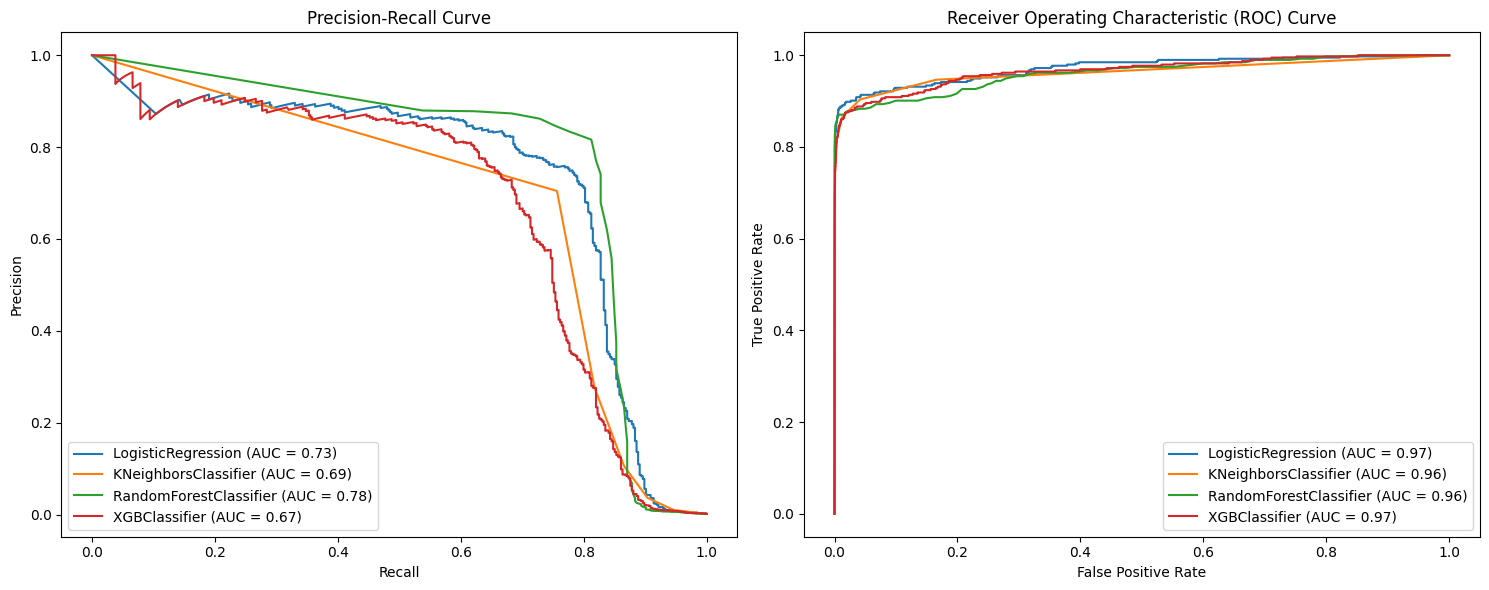

In [87]:
plot_curves_for_models(models, cc, X_train, y_train)

Els resultats de la validació creuada revelen que, malgrat la aparent separabilitat de les dades després de l'aplicació de l'undersampling, la pèrdua significativa d'informació ha afectat negativament els models. Aquesta reducció dràstica de mostres ha conduït a models que no poden separar de manera òptima les dues classes. Aquesta disminució de la capacitat discriminativa pot ser atribuïda a la pèrdua de variabilitat en les dades, la qual cosa fa que els models siguin menys robustos i eficients en la identificació de patrons rellevants per a la classificació.

### **Over-Sampling**


En aquesta secció, ens centrarem en l'oversampling del conjunt de dades per abordar el desequilibri. Analitzarem dues tècniques d'oversampling, concretament SMOTE i ADASYN. Aquest enfocament ens proporciona un avantatge respecte de l'undersampling, ja que en aquest cas no es presenta cap tipus de pèrdua d'informació deguda a l'eliminació d'exemples. No obstant això, l'augment massiu de mostres de la classe minoritària pot conduir a un sobreajustament del model, afectant la seva capacitat de generalització, i també poden sorgir problemes de sensibilitat a l'extremisme.

#### <u>*SMOTE*</u>
El Synthetic Minority Over-sampling Technique (SMOTE) és una tècnica d'over-sampling que crea mostres sintètiques en la regió entre punts de la classe minoritària. Això augmenta el conjunt de dades i millora la capacitat del model per identificar patrons en la classe minoritària.

In [30]:
smote = SMOTE(n_jobs=5)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

#### <u>*ADASYN*</u>
L'Adaptive Synthetic Sampling (ADASYN) és una variant del SMOTE que adapta el nivell d'over-sampling per a cada mostra, basant-se en la seva dificultat de classificació. Això busca millorar l'eficàcia de l'over-sampling en zones on és més necessari.

In [31]:
adasyn = ADASYN(sampling_strategy='auto', random_state=33, n_jobs=5)
X_train_ADASYN, y_train_ADASYN = adasyn.fit_resample(X_train, y_train)

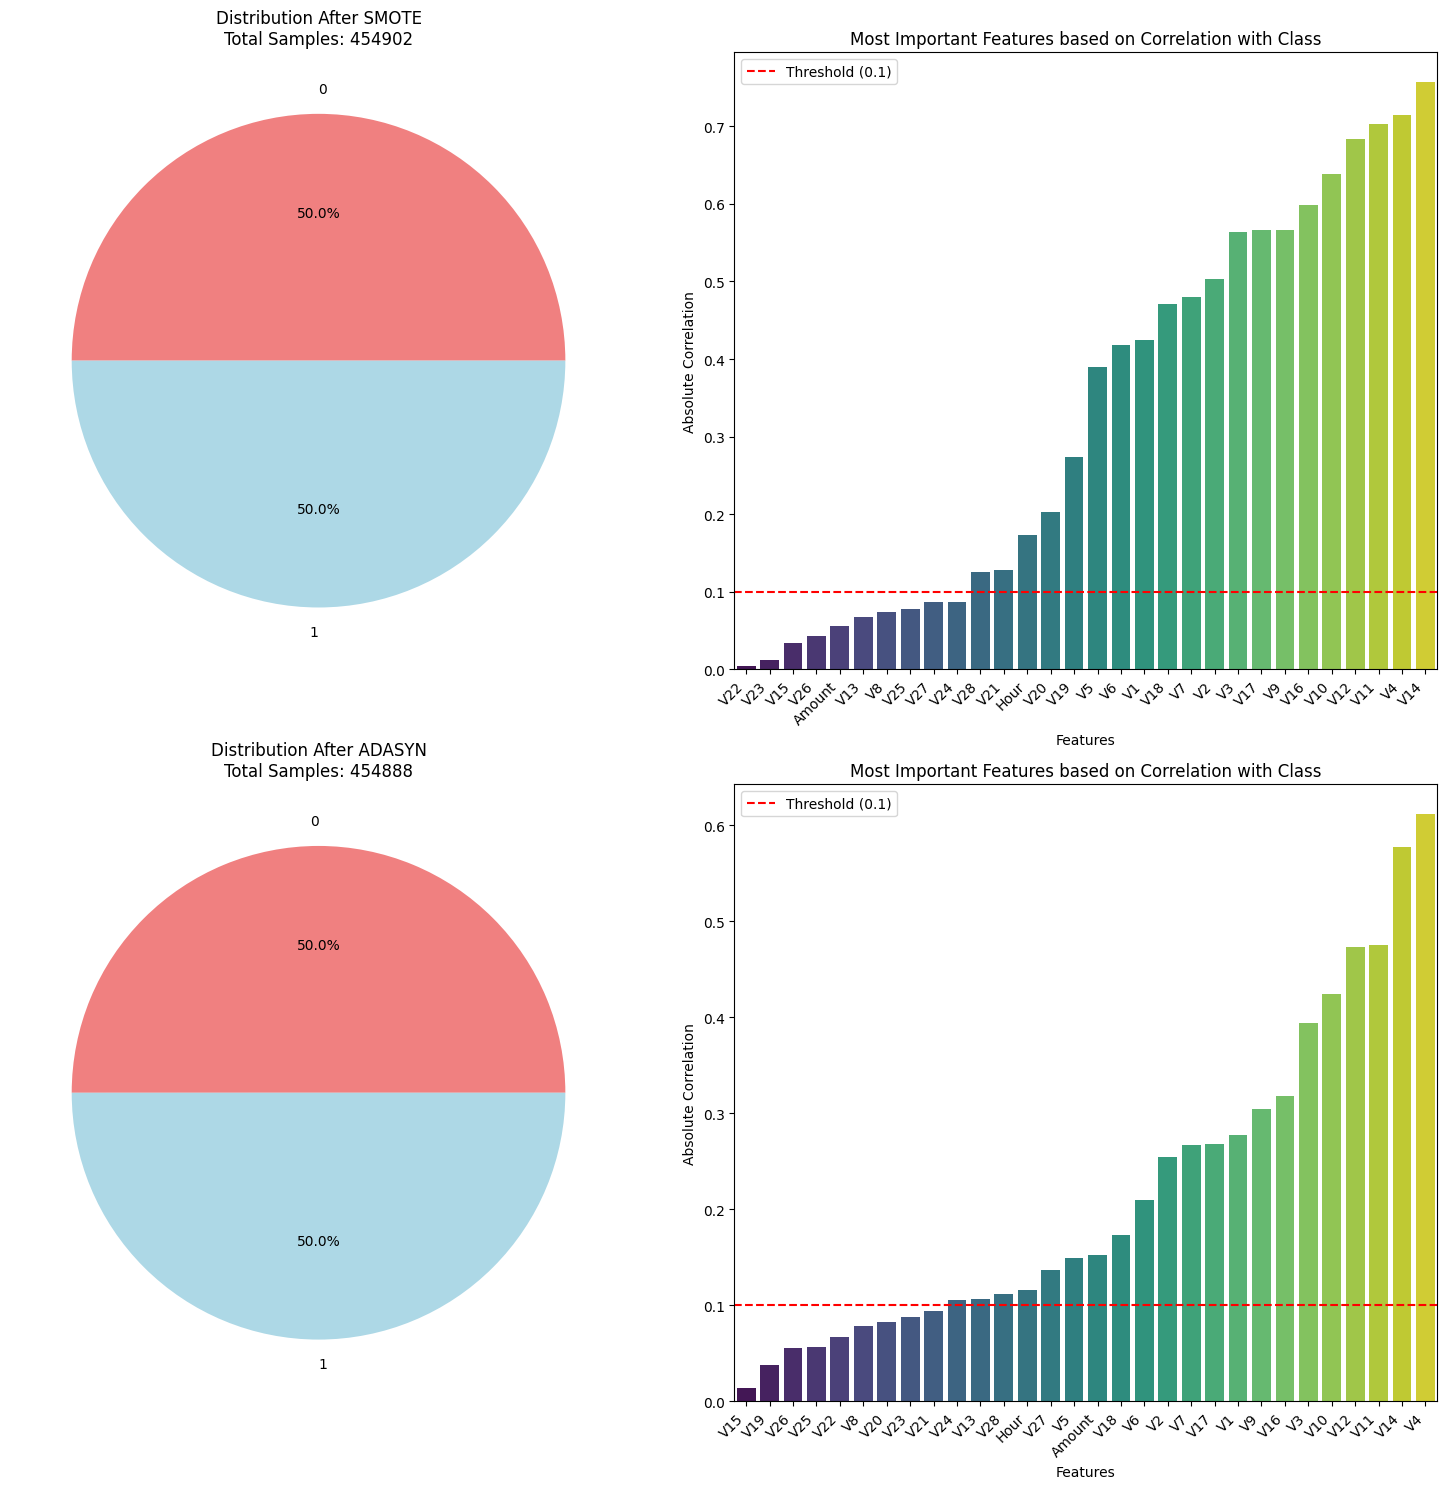

In [91]:
class_counts_after_smote = Counter(y_train_SMOTE)
class_counts_after_adasyn = Counter(y_train_ADASYN)
corr_threshold = 0.1

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.pie(class_counts_after_smote.values(), labels=class_counts_after_smote.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Distribution After SMOTE\nTotal Samples: {}'.format(sum(class_counts_after_smote.values())))

plt.subplot(2, 2, 2)
SMOTE_df = pd.concat([pd.DataFrame(X_train_SMOTE, columns=X.columns), pd.Series(y_train_SMOTE, name='Class')], axis=1)
correlation = SMOTE_df.corr()['Class'].abs().sort_values()
correlation = correlation[correlation.index != 'Class']
sns.barplot(x=correlation.index, y=correlation.values, hue=correlation.index, palette='viridis')
plt.title('Most Important Features based on Correlation with Class')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=corr_threshold, color='red', linestyle='--', label=f'Threshold ({corr_threshold})')
plt.legend()

plt.subplot(2, 2, 3)
plt.pie(class_counts_after_adasyn.values(), labels=class_counts_after_adasyn.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Distribution After ADASYN\nTotal Samples: {}'.format(sum(class_counts_after_adasyn.values())))

plt.subplot(2, 2, 4)
ADASYN_df = pd.concat([pd.DataFrame(X_train_ADASYN, columns=X.columns), pd.Series(y_train_ADASYN, name='Class')], axis=1)
correlation = ADASYN_df.corr()['Class'].abs().sort_values()
correlation = correlation[correlation.index != 'Class']
sns.barplot(x=correlation.index, y=correlation.values, hue=correlation.index, palette='viridis')
plt.title('Most Important Features based on Correlation with Class')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=corr_threshold, color='red', linestyle='--', label=f'Threshold ({corr_threshold})')
plt.legend()

plt.tight_layout()
plt.show()

Similarment a l'anàlisi de correlacions de l'undersampling, veurem que el SMOTE i l'ADASYN han canviat de manera notable la importància de les correlacions respecte al conjunt de dades original. Aquest canvi en les correlacions destaca l'efecte de les tècniques d'oversampling en la relació entre les característiques i les transaccions fraudulentes. Especialment, el SMOTE, al introduir mostres sintètiques, pot amplificar o modificar les correlacions existents, afectant la manera com les característiques es relacionen amb la classe objectiu. Aquesta transformació és crucial per entendre com les tècniques d'oversampling poden influir en la representació del conjunt de dades i, per tant, en el rendiment del model resultant.

#### Classifiers

In [8]:
models = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42)
]

In [94]:
resultsSMOTE = cross_validate_models(models, smote, X_train, y_train, metrics=['accuracy', 'precision', 'recall', 'f1_macro'], cv=stratified_kfold, resampeling='SMOTE')

,f1_macro
LogisticRegression_3879272089544194457,0.554925
KNeighborsClassifier_-7634219998417779741,0.765256
RandomForestClassifier_6939949726593806787,0.924584
XGBClassifier_-2460739881445598764,0.906557


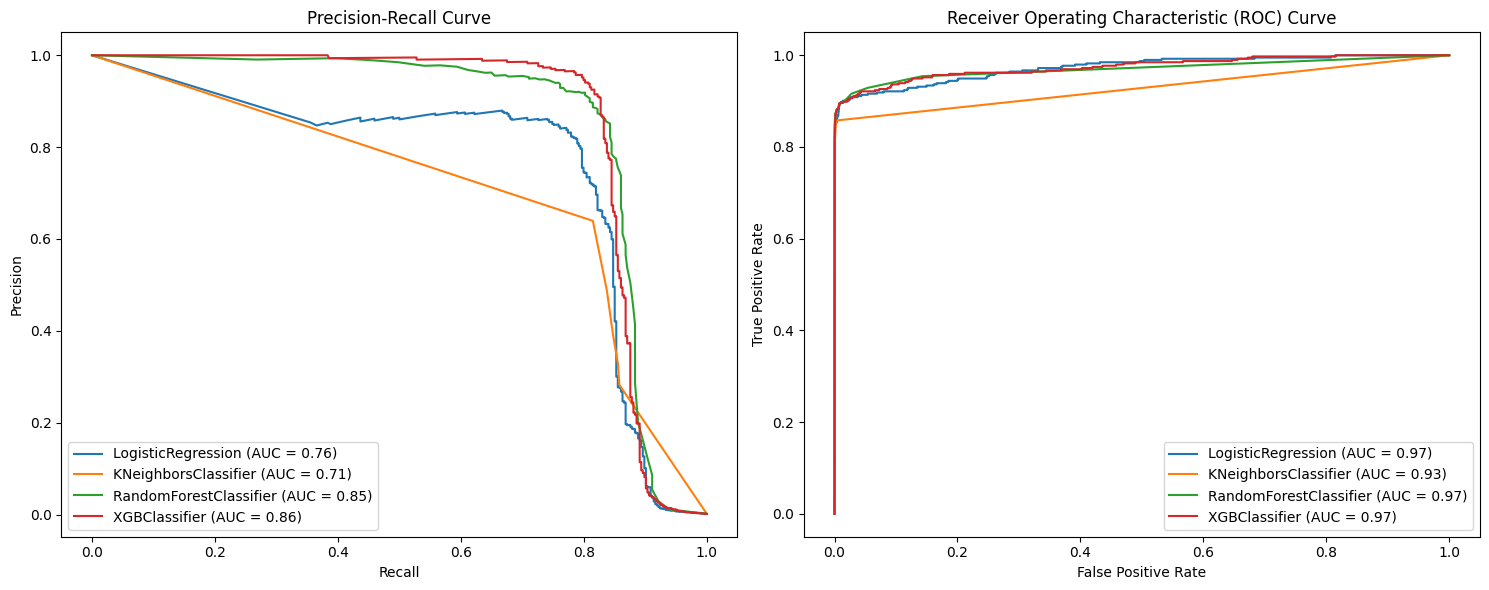

In [95]:
plot_curves_for_models(models, smote, X_train, y_train)

In [96]:
resultsADASYN = cross_validate_models(models, adasyn, X_train, y_train, metrics=['accuracy', 'precision', 'recall', 'f1_macro'], cv=stratified_kfold, resampeling='ADASYN')

,f1_macro
LogisticRegression_3879272089544194457,0.506495
KNeighborsClassifier_-7634219998417779741,0.764476
RandomForestClassifier_6939949726593806787,0.922969
XGBClassifier_-2460739881445598764,0.903420


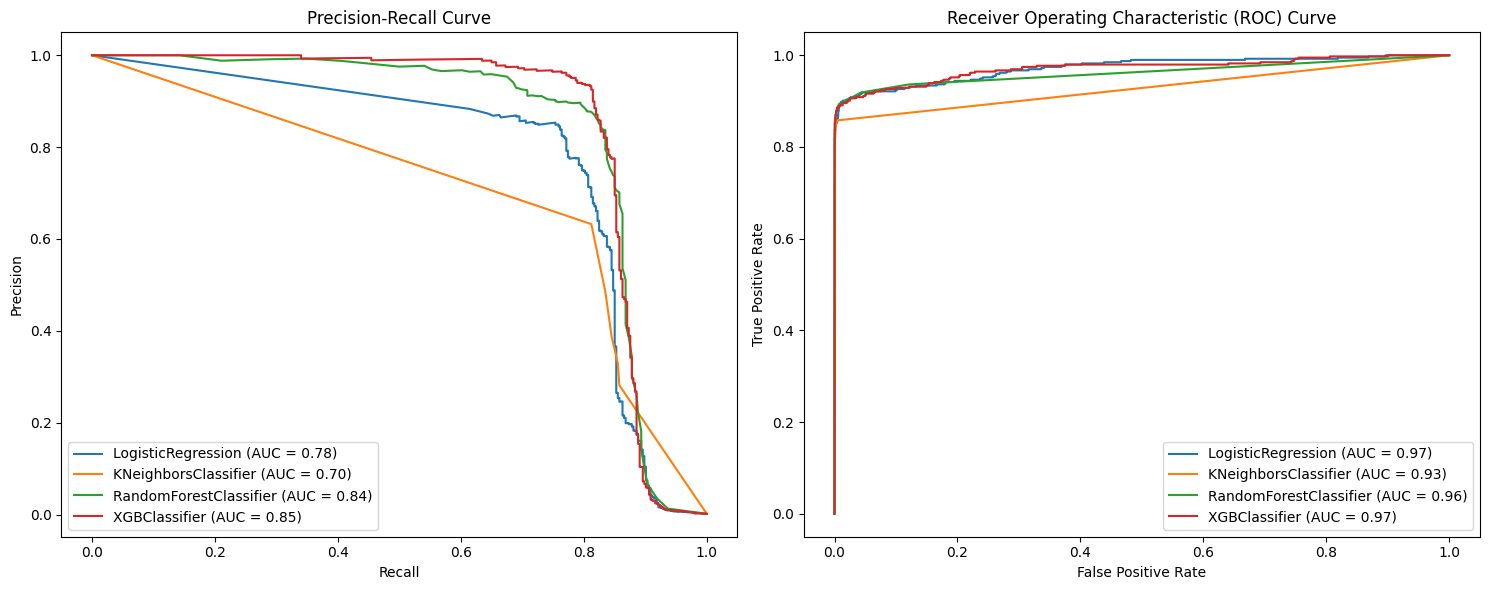

In [97]:
plot_curves_for_models(models, adasyn, X_train, y_train)

Els resultats de la validació creuada pels models entrenats amb els datasets generats per oversampling mostren una millora significativa en el rendiment, sobretot amb el model Random Forest, especialment utilitzant l'SMOTE. Aquesta millora destaca la eficàcia de les tècniques d'oversampling per abordar el desequilibri en el nostre conjunt de dades. Amb un desbalanceig tan pronunciat, l'undersampling provoca una pèrdua crítica d'informació, conduint a l'underfitting. 

### **Over-Sampling and Under-Sampling Combined**
En aquesta secció, explorarem una estratègia que combina els conceptes d'over-sampling i under-sampling per abordar de manera més completa el desequilibri present al nostre conjunt de dades. La tècnica específica que examinarem és coneguda com a SMOTEENN. Mitjançant aquest enfocament combinat, intentarem mitigar els desavantatges inherents als mètodes individuals i aconseguir una millora en la capacitat de generalització dels nostres models de detecció de frau.

#### <u>*SMOTEENN*</u>
SMOTEENN és una tècnica que combina dues estratègies, SMOTE (Synthetic Minority Over-sampling Technique) i ENN (Edited Nearest Neighbors), per abordar el desequilibri en conjunts de dades. En la primera fase, SMOTE crea mostres sintètiques per la classe minoritària, augmentant-ne la quantitat. A continuació, ENN elimina les instàncies que es consideren mal classificades pel seu entorn més proper. 

In [26]:
smoteenn = SMOTEENN(random_state=42, n_jobs=5)
X_train_SMOTEENN, y_train_SMOTEENN = smoteenn.fit_resample(X_train, y_train)

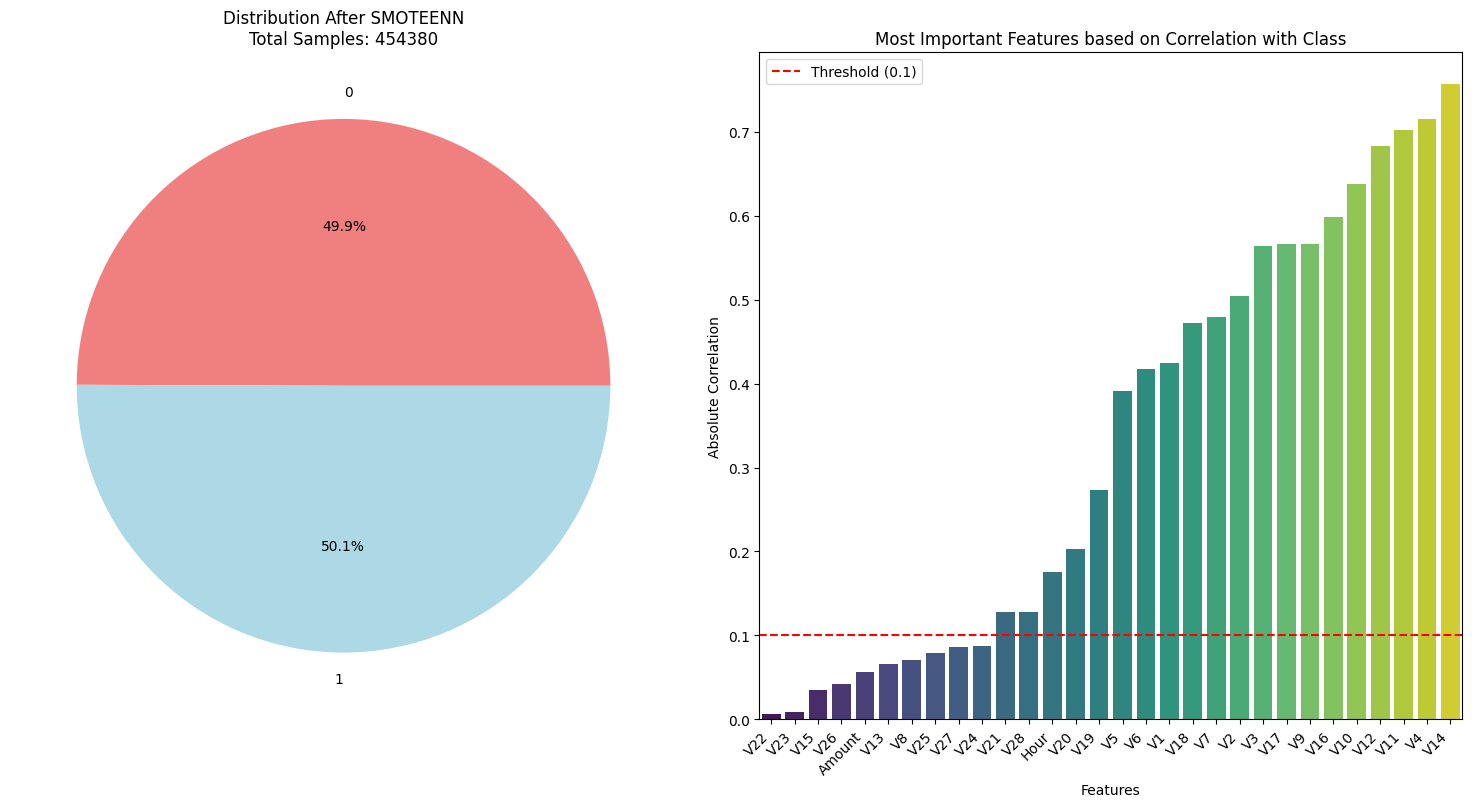

In [100]:
class_counts_after_SMOTEENN  = Counter(y_train_SMOTEENN)
corr_threshold = 0.1

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.pie(class_counts_after_SMOTEENN .values(), labels=class_counts_after_SMOTEENN .keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Distribution After SMOTEENN\nTotal Samples: {}'.format(sum(class_counts_after_SMOTEENN .values())))

plt.subplot(2, 2, 2)
SMOTEENN_df = pd.concat([pd.DataFrame(X_train_SMOTEENN, columns=X.columns), pd.Series(y_train_SMOTEENN, name='Class')], axis=1)
correlation = SMOTEENN_df.corr()['Class'].abs().sort_values()
correlation = correlation[correlation.index != 'Class']
sns.barplot(x=correlation.index, y=correlation.values, hue=correlation.index, palette='viridis')
plt.title('Most Important Features based on Correlation with Class')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=corr_threshold, color='red', linestyle='--', label=f'Threshold ({corr_threshold})')
plt.legend()

plt.tight_layout()
plt.show()

#### Classifiers

In [9]:
models = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42)
]

In [103]:
resultsSMOTEENN = cross_validate_models(models, smoteenn, X_train, y_train, cv=stratified_kfold, resampeling='SMOTEENN')

,f1_macro
LogisticRegression_3879272089544194457,0.554011
KNeighborsClassifier_-7634219998417779741,0.742113
RandomForestClassifier_6939949726593806787,0.912044
XGBClassifier_-2460739881445598764,0.884611


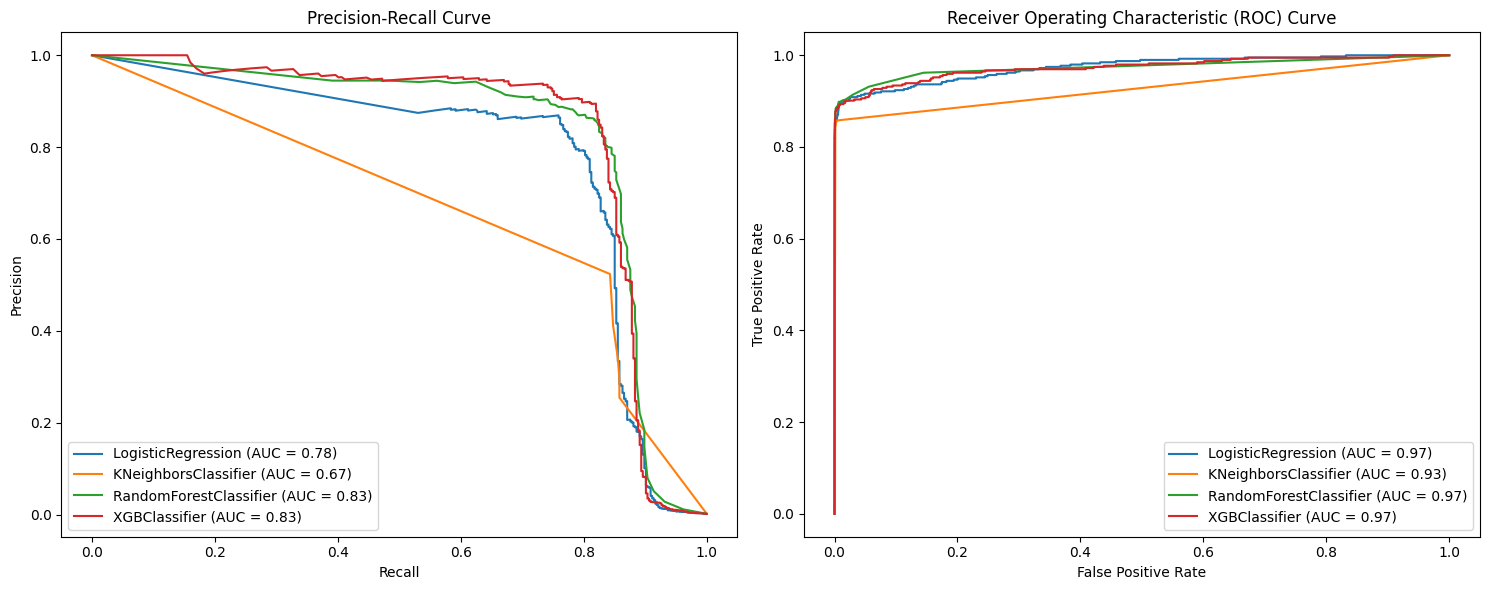

In [29]:
plot_curves_for_models(models, smoteenn, X_train, y_train)

Com es pot observar, l'SMOTEENN ha empitjorat els resultats en comparació amb l'SMOTE. Aquest lleuger empitjorament en el rendiment pot ser atribuït al fet que l'ENN ha eliminat mostres que podrien ser crítiques per a la correcta separació de les classes. Encara que la combinació de SMOTE i ENN té l'objectiu d'aportar beneficis combinats d'oversampling i undersampling, en aquest cas concret, sembla que degut a la naturalesa de les dades el SMOTEENN ha afectat negativament el rendiment general del model.

### **Aprenentatge Sensible al Cost**
En aquesta secció, explorarem l'enfocament de l'Aprenentatge Sensible al Cost per abordar els conjunts de dades desbalancejats. Aquesta tècnica busca equilibrar l'impacte dels errors en les classes desbalancejades ajustant la funció de cost per reflectir la importància relativa de cadascuna de les classes. Analitzarem models senzills que incorporin la consideració del cost en la seva estructura, així com també explorarem l'ús d'un Classificador de Votació construït amb aquests models, amb l'objectiu de millorar la capacitat del model per gestionar el desequilibri inherent en aquests tipus de dades.

In [18]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
knn = KNeighborsClassifier(weights='distance')
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
xgb =XGBClassifier(scale_pos_weight=1 / 0.17, random_state=42)

models = [lr, knn, rf, xgb]

#### *Simple Cost-Sensitive Models*
    

In [99]:
resultsCostSensitive = cross_validate_sensitive(models, X_train, y_train)

,f1_macro
LogisticRegression_-8303857189465698474,0.561600
KNeighborsClassifier_-3336143508539130970,0.909363
RandomForestClassifier_1858126956338585078,0.919852
XGBClassifier_-2781219804619487201,0.931367


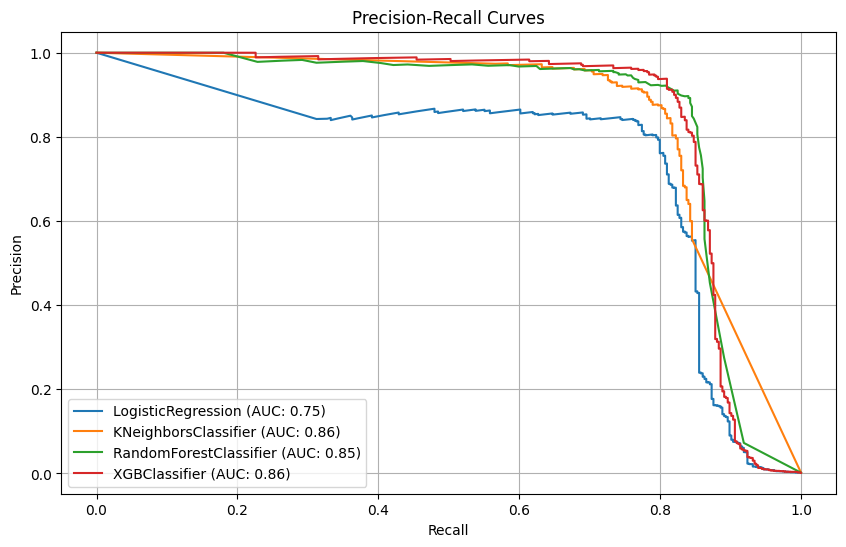

In [7]:
plot_pr_curve(models, X_train, y_train)

#### *Voting Classifier from Cost-Sensitive Models*

In [19]:
models = [
    ('lr', lr),
    ('knn', knn),
    ('rf', rf),
    ('xgb', xgb)
]

voting_classifier = VotingClassifier(estimators = models, voting='soft')

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_function = make_scorer(f1_score, average='macro')

f1_macro_scores = cross_val_score(voting_classifier, X_train, y_train, cv=cv, scoring=scoring_function)

f1_macro_df = pd.DataFrame(f1_macro_scores.mean(), columns=['f1_macro'], index=["VotingClassifier"])
display(f1_macro_df)

,f1_macro
VotingClassifier,0.938196


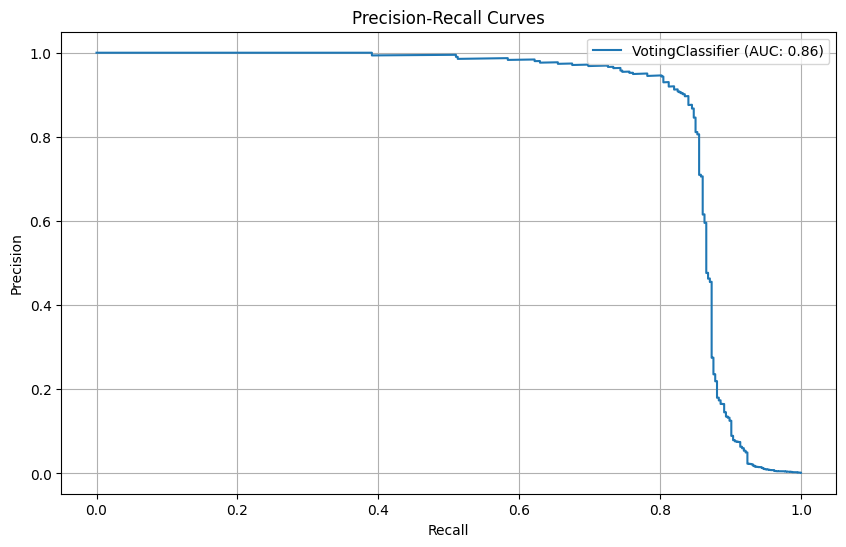

In [9]:
plot_pr_curve([voting_classifier], X_train, y_train)

Observem que tant el XGB amb aprenentatge sensible al cost com la utilització d'un VotingClassifier en conjunt amb els models entrenats anteriorment amb aquesta tecnica, ens permet aconseguir un millor rendiment en comparació amb les tècniques de remostreig anteriorment vistes. Especialment, el Voting Classifier ha aconseguit una F1 macro de 0.938, superant així la implementació del RandomForest amb l'estratègia de remostreig SMOTE. Aquest resultat pot estar dont per la naturalesa específica del conjunt de dades, com la distribució de les classes i la complexitat dels patrons.

## Anàlisi del Model Final i Conclusions

En aquesta secció, procedirem amb una avaluació detallada del nostre model en el conjunt de test i explorarem a fons la naturalesa dels resultats obtinguts. Especialment, ens centrarem en el rendiment del millor classificador, que s'ha revelat com el **Voting Classifier amb aprenentatge sensible al cost**. Analitzarem les mètriques clau, les característiques més influents i la capacitat del model per abordar el desequilibri inherent en les transaccions fraudulentes i no fraudulentes.

In [20]:
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=42)),
                             ('knn', KNeighborsClassifier(weights='distance')),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, de...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

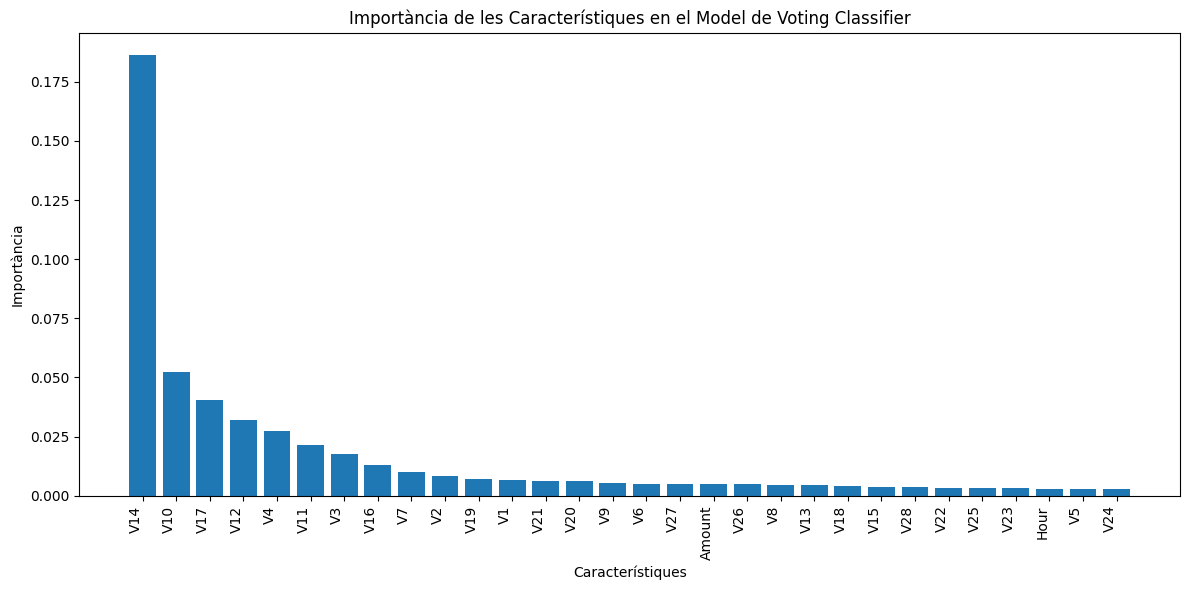

In [16]:
all_feature_importances = np.zeros((len(voting_classifier.estimators_), X.shape[1]))

for i, estimator in enumerate(voting_classifier.estimators_):
    if hasattr(estimator, 'feature_importances_'):
        all_feature_importances[i, :] = estimator.feature_importances_

mean_feature_importances = np.mean(all_feature_importances, axis=0)

feature_labels = X.columns
sorted_indices = mean_feature_importances.argsort()[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), mean_feature_importances[sorted_indices], tick_label=feature_labels[sorted_indices])
plt.xticks(rotation=90, ha='right')
plt.xlabel('Característiques')
plt.ylabel('Importància')
plt.title('Importància de les Característiques en el Model de Voting Classifier')
plt.tight_layout()
plt.show()


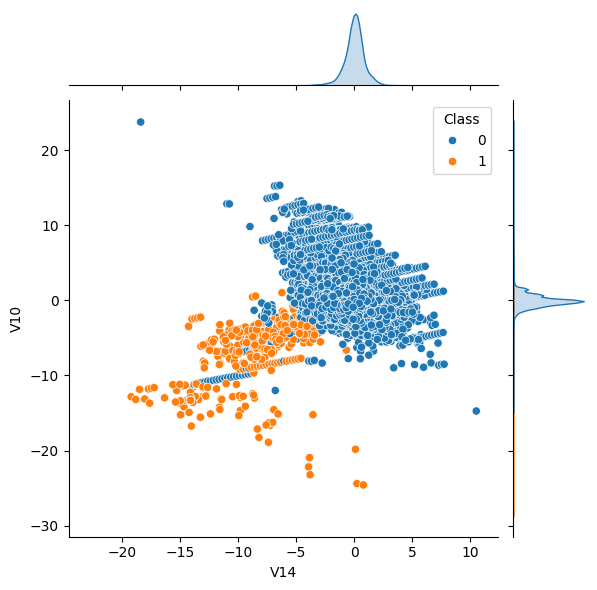

In [17]:
sns.jointplot(data=df, x='V14', y='V10', hue='Class')

Podem notar que la característica més rellevant per al nostre model és la V14, amb una diferència significativa. A més, en analitzar les dues característiques més importants (V14 i V10) mitjançant un joinplot, es destaca una notable separabilitat entre les classes. Aquesta observació suggereix que l'ús combinat d'aquestes dues característiques derivades del PCA mostra una distinció clara entre les transaccions legítimes i les fraudulentes. Aquesta separabilitat pot indicar que les característiques V14 i V10 aporten una quantitat substancial d'informació al model per a la detecció de frau en les transaccions bancàries.

### Test

In [21]:
prediction = voting_classifier.predict(X_test_scaled)

In [22]:
report = classification_report(y_test, prediction, digits=4)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9277    0.7857    0.8508        98

    accuracy                         0.9995     56962
   macro avg     0.9637    0.8928    0.9253     56962
weighted avg     0.9995    0.9995    0.9995     56962



Els resultats del test coincideixen amb les expectatives generades pel procés de validació creuada, confirmant així una correcta implementació d'aquesta tècnica. Aquesta concordança entre els resultats del test i la validació creuada destaca la fiabilitat de la validació creuada implementada com a mètode que proporciona una estimació representativa del rendiment del nostre model amb exemples no vistos.

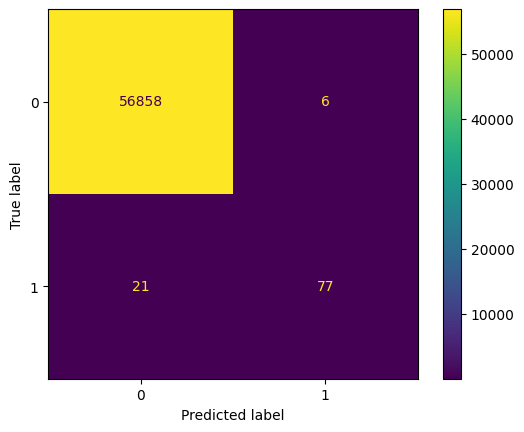

In [23]:
ConfusionMatrixDisplay(confusion_matrix(y_test, prediction)).plot()

Com podem observar, la majoria dels errors que hem comès es troben en la predicció d'exemples com a no fraudulents quan, de fet, eren fraudulents. Aquest fenomen es veu de manera mes clara en les corves PR on hem notat que no aconseguíem mai una recall superior al 82% sense perdre dràsticament la precisió. Això suggereix que hi pot haver uns pocs exemples de frau que s'assemblen molt a transaccions legítimes.

Aquest fenomen podria ser resultat de dues raons principals:

- Potser aquests exemples van ser etiquetats incorrectament des del principi.
- Potser els estafadors utilitzen tècniques molt avançades per cometre frau, de manera que les transaccions fraudulentas siguin pràcticament indistingibles de les transaccions legítimes.

A continuació, investigarem les transaccions mal classificades i l'impacte que aquestes poden tenir per a la banca.

In [52]:
pd.set_option('display.max_columns', None)


incorrectly_classified_indices = (y_test == 1) & (prediction == 0)
missed_fraud = pd.DataFrame(X_test[incorrectly_classified_indices], columns=X.columns)
missed_fraud_AH = missed_fraud[['Amount', 'Hour']]
print('Transaccions fraudulentes mal classificades:')
display(missed_fraud_AH .transpose())


Transaccions fraudulentes mal classificades:


,83297,229730,68067,124036,214775,10497,263080,215953,39183,231978,146790,124176,191267,251881,118308,213092,57248,245347,91671,157918,222419
Amount,319.2,2.22,519.9,129.0,0.69,3.79,1.0,0.77,776.83,8.0,829.41,1.0,7.18,3.14,30.14,22.47,7.58,2.47,290.18,635.1,0.0
Hour,16.0,40.00,14.0,21.0,38.00,4.00,44.0,38.00,11.00,40.0,24.00,21.0,35.00,43.00,20.00,38.00,13.00,42.00,17.00,30.0,39.0


Observem que hi ha diverses transaccions amb un valor elevat, i si aquestes passessin desapercebudes, podrien ocasionar un cost considerable per a la banca.

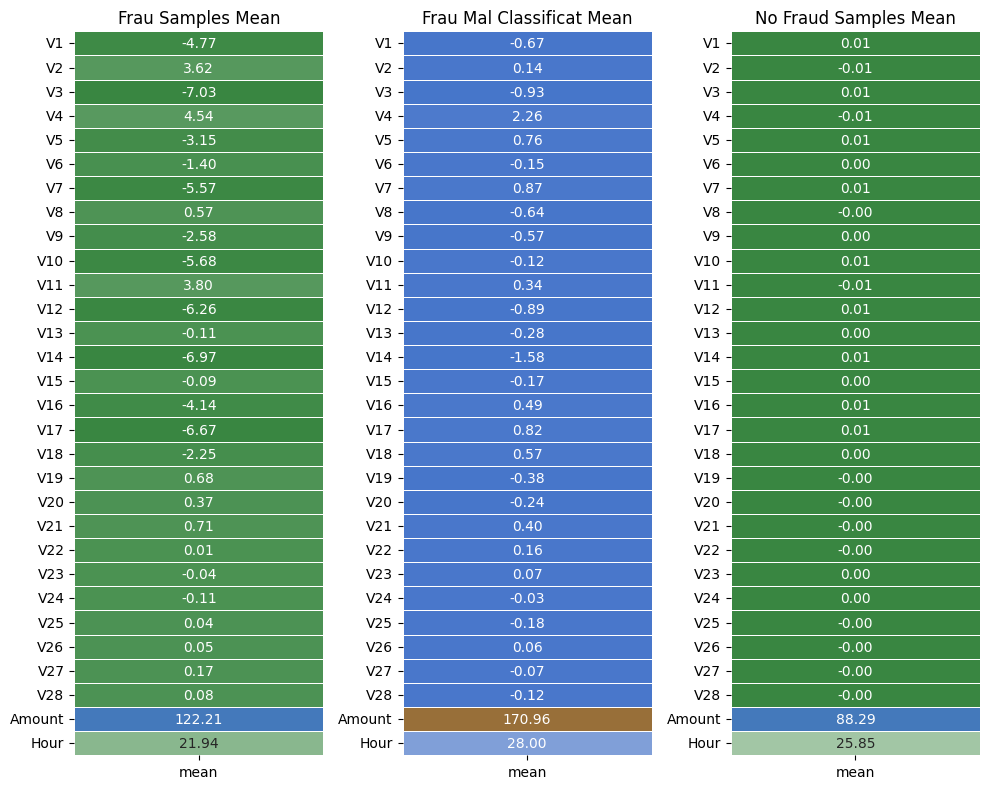

In [63]:
nofraud = df[df['Class'] == 0].drop(['Class', 'Time'], axis=1)
fraud = df[df['Class'] == 1].drop(['Class', 'Time'], axis=1)

mean_fraud = fraud.describe().T
mean_nofraud = nofraud.describe().T
mean_missed_fraud = missed_fraud.describe().T

cmap1 = sns.diverging_palette(130, 250, as_cmap=True)
cmap2 = sns.diverging_palette(255, 50, as_cmap=True)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))

plt.subplot(1, 3, 1)
sns.heatmap(mean_fraud[['mean']][:], annot=True, cmap=cmap1, linewidths=0.5, linecolor='white', cbar=False, fmt='.2f')
plt.title('Frau Samples Mean')

plt.subplot(1, 3, 2)
sns.heatmap(mean_missed_fraud[['mean']][:], annot=True, cmap=cmap2, linewidths=0.5, linecolor='white', cbar=False, fmt='.2f')
plt.title('Frau Mal Classificat Mean')

plt.subplot(1, 3, 3)
sns.heatmap(mean_nofraud[['mean']][:], annot=True, cmap=cmap1, linewidths=0.5, linecolor='white', cbar=False, fmt='.2f')
plt.title('No Fraud Samples Mean')

fig.tight_layout()

fig.tight_layout()

Com podem observar, la mitjana de les transaccions fraudulentes que el model no ha pogut classificar correctament mostra valors molt més semblants a les transaccions legítimes, especialment en les característiques amb més pes per a detectar frau, com ara V14, V10, V17 i V12, que ara s'apropen al valor mitjà de les transaccions no fraudulentes. A més a més, observem que aquest tipus de transaccions són particularment costoses per al banc, ja que la seva mitjana de quantitat a transferir és molt alta.

## **Conclusions**

En aquesta anàlisi exhaustiva, hem aprofundit en les tècniques i estratègies utilitzades per abordar el desafiament de la detecció de frau en un conjunt de dades desbalancejat de transaccions amb targeta de crèdit.

**Rendiment del Model:**

Hem optat per un enfocament basat en un Voting Classifier amb aprenentatge sensible al cost, integrant models com Random Forest i XGBoost. Mitjançant la validació creuada, hem ajustat la configuració per maximitzar la F1 Macro, assegurant una avaluació equitativa del rendiment en totes dues classes. L'anàlisi de les característiques ha ressaltat la importància de V14 i altres variables derivades del PCA en la separació entre transaccions legítimes i fraudulentes.

**Comparació amb Altres Estratègies:**

L'exploració de tècniques de remostreig, com RandomUnderSampler i SMOTE, ha revelat que l'oversampling amb SMOTE i ADASYN ha millorat significativament la F1 Macro. L'ús de l'Aprenentatge Sensible al Cost ha estat fonamental, amb el Voting Classifier obtinguent una F1 Macro de 0.938 en la validació creuada i de 0.926 en el conjunt de proves.

**Limitacions i Desafiaments:**

A pesar de l'èxit general, hem identificat un compromís entre recall i precisió, amb algunes transaccions fraudulentes que es presenten com a difícils de distingir. La Recall en cap model ha superat el 80%, possiblement a causa de la complexitat inherent d'algunes transaccions o tècniques sofisticades utilitzades pels estafadors.

**Implicacions Pràctiques:**

L'ús d'aquest model eficient té implicacions pràctiques significatives en la prevenció de pèrdues econòmiques associades a transaccions fraudulentes. La identificació precisa de transaccions sospitoses és crucial per a les institucions financeres per gestionar pèrdues i mantenir la confiança dels clients.

**Suggeriments per a Futures Investigacions i Millores:**

Per abordar transaccions fraudulentes difícils de distinguir, es podrien explorar models especialitzats i tècniques d'aprenentatge no supervisat, com autoencoders. Millorar la interpretabilitat del model amb dades no encriptades també és crucial per a la comprensió del seu comportament.

**Conclusió Final i Perspectiva General:**

En resum, la combinació d'un Voting Classifier amb aprenentatge sensible al cost ha demostrat ser una solució robusta per a la detecció de frau en transaccions amb targeta de crèdit. Tot i les limitacions, aquest enfocament ha superat altres estratègies, amb implicacions pràctiques rellevants per a institucions financeres. El futur de la recerca inclou l'exploració de models més especialitzats i millores en la interpretabilitat per abordar les limitacions actuals del sistema.

|               | Precision | Recall | F1-Score | Support |
|-------------- |-----------|--------|----------|---------|
| Class 0       | 0.9996    | 0.9999 | 0.9998   | 56864   |
| Class 1       | 0.9277    | 0.7857 | 0.8508   | 98      |
| Accuracy      |           |        | 0.9995   | 56962   |
| Macro Avg     | 0.9637    | 0.8928 | 0.9253   | 56962   |
| Weighted Avg  | 0.9995    | 0.9995 | 0.9995   | 56962   |
